<h1><center>Resources</center></h1>

<h1><center>Global stuff</center></h1>

<h2>Imports</h2>

In [1]:
import numpy
import matplotlib.pyplot as pyplot
import argparse
import json
import ast
import sys
import os
import cProfile
import time
import pyprof2calltree
import functools # For creating a user-defined comparison operator
from scipy import stats # For Kendall Tau & Spearman Rho
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform
import scipy.sparse as sparse
import random
from sklearn.cluster import KMeans
from pydpp.dpp import DPP
!pip install tikzplotlib
import tikzplotlib

<h2>Constants</h2>

In [2]:
# Initialization
parser = argparse.ArgumentParser()

In [3]:
# Problem description
_ = parser.add_argument("--nb_criteria",
                        help="Number of criteria for the ground truth decision maker",
                        type=int,
                        default=11)
_ = parser.add_argument("--nb_profiles",
                        help="Number of profiles for the ground truth decision maker",
                        type=int,
                        default=3)
_ = parser.add_argument("--nb_alternatives",
                        help="Number of alternatives from which to draw comparisons to submit to the decision maker",
                        type=int,
                        default=50)
_ = parser.add_argument("--eval_on_test_set_1",
                        help="Indicates if we evaluate generalization ability on unseen comparisons of the train alternatives",
                        type=ast.literal_eval,
                        default=True)
_ = parser.add_argument("--nb_alternatives_test_set_2",
                        help="Number of alternatives to evaluate generalization ability on unseen alternatives",
                        type=int,
                        default=300)
_ = parser.add_argument("--nb_comparisons",
                        help="Number of comparisons of alternatives to submit to the decision maker",
                        type=int,
                        default=100)
_ = parser.add_argument("--debug_mode",
                        help="To add plots in the script",
                        type=ast.literal_eval,
                        default=True)
_ = parser.add_argument("--random_seed",
                        help="Experiment random seed",
                        type=int,
                        default=None)
_ = parser.add_argument("--output_directory",
                        help="Directory where to produce figures",
                        type=str,
                        default="../output/learn_SRMP/")

In [4]:
# Default arguments of function 'mutation_random_profile_perturbation'
_ = parser.add_argument("--mutation_random_profile_perturbation__perturbation_scale",
                        help="Argument 'perturbation_scale' of function 'mutation_random_profile_perturbation'",
                        type=float,
                        default=0.1)
_ = parser.add_argument("--mutation_random_profile_perturbation__individual_criterion_proba",
                        help="Argument 'individual_criterion_proba' of function 'mutation_random_profile_perturbation'",
                        type=float,
                        default=1.0)

In [5]:
# Default arguments of function 'mutation_random_weights_perturbation'
_ = parser.add_argument("--mutation_random_weights_perturbation__perturbation_scale",
                        help="Argument 'perturbation_scale' of function 'mutation_random_weights_perturbation'",
                        type=float,
                        default=0.1)
_ = parser.add_argument("--mutation_random_weights_perturbation__individual_criterion_proba",
                        help="Argument 'individual_criterion_proba' of function 'mutation_random_weights_perturbation'",
                        type=float,
                        default=1.0)

In [6]:
# Default arguments of function 'mutation_shrink_profiles'
_ = parser.add_argument("--mutation_shrink_profiles__shrink_factor",
                        help="Argument 'shrink_factor' of function 'mutation_shrink_profiles'",
                        type=float,
                        default=0.7)
_ = parser.add_argument("--mutation_shrink_profiles__individual_criterion_proba",
                        help="Argument 'individual_criterion_proba' of function 'mutation_shrink_profiles'",
                        type=float,
                        default=1.0)

In [7]:
# Default arguments of function 'mutation_expand_profiles'
_ = parser.add_argument("--mutation_expand_profiles__expand_factor",
                        help="Argument 'expand_factor' of function 'mutation_expand_profiles'",
                        type=float,
                        default=0.7)
_ = parser.add_argument("--mutation_expand_profiles__individual_criterion_proba",
                        help="Argument 'individual_criterion_proba' of function 'mutation_expand_profiles'",
                        type=float,
                        default=1.0)

In [8]:
# Default arguments of function 'prepare_new_population'
_ = parser.add_argument("--prepare_new_population__elitism_ratio",
                        help="Argument 'elitism_ratio' of function 'prepare_new_population'",
                        type=float,
                        default=0.4)
_ = parser.add_argument("--prepare_new_population__random_ratio",
                        help="Argument 'random_ratio' of function 'prepare_new_population'",
                        type=float,
                        default=0.0)

In [9]:
# Default arguments of function 'select_solutions'
_ = parser.add_argument("--select_solutions__nb_solutions",
                        help="Argument 'nb_solutions' of function 'select_solutions'",
                        type=int,
                        default=2)
_ = parser.add_argument("--select_solutions__strategy",
                        help="Argument 'strategy' of function 'select_solutions'",
                        type=str,
                        choices=["roulette", "DPP", "DPP+roulette"],
                        default="DPP+roulette")
_ = parser.add_argument("--select_solutions__similarity_metric",
                        help="Argument 'metric' of function 'compute_similarity_matrix'",
                        type=str,
                        choices=["kendall-tau", "spearman-rho", "l1-norm", "l2-norm"],
                        default="l1-norm")

In [10]:
# Default arguments of function 'make_crossover'
_ = parser.add_argument("--make_crossover__crossover_swap_weights_probability",
                        help="Partial argument 'crossover_probability' of function 'make_crossover'",
                        type=float,
                        default=0.0)
_ = parser.add_argument("--make_crossover__crossover_swap_orders_probability",
                        help="Partial argument 'crossover_probability' of function 'make_crossover'",
                        type=float,
                        default=0.0)
_ = parser.add_argument("--make_crossover__crossover_swap_profiles_probability",
                        help="Partial argument 'crossover_probability' of function 'make_crossover'",
                        type=float,
                        default=0.0)
_ = parser.add_argument("--make_crossover__crossover_mix_criteria_probability",
                        help="Partial argument 'crossover_probability' of function 'make_crossover'",
                        type=float,
                        default=0.5)
_ = parser.add_argument("--make_crossover__crossover_mix_criteria_and_weights_probability",
                        help="Partial argument 'crossover_probability' of function 'make_crossover'",
                        type=float,
                        default=0.5)

In [11]:
# Default arguments of function 'make_mutation'
_ = parser.add_argument("--make_mutation__mutation_random_profile_perturbation_probability",
                        help="Partial argument 'mutation_probability' of function 'make_mutation'",
                        type=float,
                        default=0.0)
_ = parser.add_argument("--make_mutation__mutation_random_weights_perturbation_probability",
                        help="Partial argument 'mutation_probability' of function 'make_mutation'",
                        type=float,
                        default=0.2)
_ = parser.add_argument("--make_mutation__mutation_shrink_profiles_probability",
                        help="Partial argument 'mutation_probability' of function 'make_mutation'",
                        type=float,
                        default=0.2)
_ = parser.add_argument("--make_mutation__mutation_expand_profiles_probability",
                        help="Partial argument 'mutation_probability' of function 'make_mutation'",
                        type=float,
                        default=0.0)
_ = parser.add_argument("--make_mutation__mutation_partially_reverse_order_probability",
                        help="Partial argument 'mutation_probability' of function 'make_mutation'",
                        type=float,
                        default=0.2)

In [12]:
# Default arguments of function 'keep_or_drop_children'
_ = parser.add_argument("--keep_or_drop_children__survival_probability",
                        help="Argument 'survival_probability' of function 'keep_or_drop_children'",
                        type=float,
                        default=0.05)

In [13]:
# Default arguments of function 'estimate_decision_maker'
_ = parser.add_argument("--estimate_decision_maker__return_k_best",
                        help="Argument 'return_k_best' of function 'estimate_decision_maker'",
                        type=int,
                        default=1)
_ = parser.add_argument("--estimate_decision_maker__population_size",
                        help="Argument 'population_size' of function 'estimate_decision_maker'",
                        type=int,
                        default=300)
_ = parser.add_argument("--estimate_decision_maker__stop_after_non_evolving",
                        help="Argument 'stop_after_non_evolving' of function 'estimate_decision_maker'",
                        type=int,
                        default=50)
_ = parser.add_argument("--estimate_decision_maker__check_identical_ratio",
                        help="Argument 'check_identical_ratio' of function 'estimate_decision_maker'",
                        type=float,
                        default=0.1)
_ = parser.add_argument("--estimate_decision_maker__nb_profiles",
                        help="Argument 'nb_profiles' of function 'estimate_decision_maker'",
                        type=int,
                        default=3)

In [14]:
# Parse and transmit to functions file
try :
    get_ipython()
    ARGS = parser.parse_args(args=[])
except :
    ARGS = parser.parse_args()

<h2>Other stuff</h2>

In [15]:
# Random seed
if ARGS.random_seed != None :
    numpy.random.seed(ARGS.random_seed)

<h1><center>Functions</center></h1>

<h2>Misc</h2>

In [16]:
def get_arg_value (argument_name, user_provided_value) :
    
    ###########################################################################################################
    """
        Retrieves the default value for an argument if needed.
        --
        In:
            * argument_name: Argument to retrieve.
            * user_provided_value: Value provided to the argument by the user.
        Out:
            * argument: Value of the asked argument.
    """
    ###########################################################################################################
    
    # User gets precedence, then we check global variable
    if user_provided_value is not None :
        return user_provided_value
    elif argument_name in ARGS :
        return ARGS.__dict__[argument_name]
    else :
        raise Exception("No default value provided for argument '" + argument_name + "'")

In [17]:
def start_profiling () :

    ###########################################################################################################
    """
        Starts profiling execution times in the code.
        --
        In:
            * None.
        Out:
            * None.
    """
    ###########################################################################################################

    # Create global object
    global profiler
    profiler = cProfile.Profile()
    profiler.enable()

In [18]:
def stop_profiling () :

    ###########################################################################################################
    """
        Stops profiling execution times in the code, and shows results.
        --
        In:
            * None.
        Out:
            * None.
    """
    ###########################################################################################################

    # Get stats and visualize
    global profiler
    profiler.create_stats()
    pyprof2calltree.visualize(profiler.getstats())

In [19]:
def create_directory_for (file_name) :

    ###########################################################################################################
    """
        Creates the directory for the given file name if it does not exist.
        --
        In:
            * file_name: Directory to create, or file for which we want to create a directory.
        Out:
            * None.
    """
    ###########################################################################################################

    # Creates the corresponding directory
    dir_name = os.path.dirname(file_name)
    os.makedirs(dir_name, exist_ok=True)

<h2>Plotting</h2>

In [20]:
def plot_decision_maker (decision_maker, alternatives=[], title="", file_name=None) :

    ###########################################################################################################
    """
        Plots a decision maker.
        --
        In:
            * decision_maker: Decision maker to plot.
            * alternatives: List of alternatives to plot with the decision maker.
            * title: Complementary information to plot in the title.
            * file_name: Where to save the results.
        Out:
            * None.
    """
    ###########################################################################################################

    # Vertical bars
    figure = pyplot.figure(figsize=(20, 10))
    nb_criteria = decision_maker["profiles"].shape[1]
    for i in range(nb_criteria) :
        pyplot.plot([i, i], [0, 1], "k")

    # Profiles
    nb_profiles = decision_maker["profiles"].shape[0]
    for i in range(nb_profiles) :
        plotted = pyplot.plot(range(nb_criteria), decision_maker["profiles"][i], ":*")
        pyplot.text(-0.02 * nb_criteria, decision_maker["profiles"][i][0], "p" + str(i), color=plotted[-1].get_color())
        pyplot.text(nb_criteria - 1 + 0.01 * nb_criteria, decision_maker["profiles"][i][-1], "p" + str(i), color=plotted[-1].get_color())
    
    # Alternatives
    for alternative in alternatives :
        plotted = pyplot.plot(range(nb_criteria), alternative["profile"], "-*", label=alternative["id"])
        pyplot.text(-0.02 * nb_criteria, alternative["profile"][0], "a" + str(alternative["id"]), color=plotted[-1].get_color())
        pyplot.text(nb_criteria - 1 + 0.01 * nb_criteria, alternative["profile"][-1], "a" + str(alternative["id"]), color=plotted[-1].get_color())
    
    # Plot decorations
    pyplot.xticks(range(nb_criteria), ["w" + str(i) + " =\n" + str(decision_maker["weights"][i]) for i in range(nb_criteria)], rotation=45)
    pyplot.yticks([0, 1])
    figure.gca().set_frame_on(False)
    pyplot.tight_layout()
    pyplot.title("dm" + str(decision_maker["id"]) + "\n" + " -> ".join("p" + str(o) for o in decision_maker["order"]) + ("\n" + title if title != "" else ""))
    pyplot.show()
    
    # Save
    if file_name is not None :
        create_directory_for(file_name)
        figure.savefig(file_name, bbox_inches="tight")

In [21]:
def plot_matrix (matrix, rows_labels="", cols_labels="", rows_title="", cols_title="", title="", colorbar=False, round_values=None, file_name=None) :

    ###########################################################################################################
    """
        Plots a matrix.
        --
        In:
            * matrix: Matrix to plot.
            * rows_labels: Labels associated with the rows.
            * cols_labels: Labels associated with the columns.
            * title: Figure title.
            * colorbar: Set to True to plot a colorbar.
            * round_values: Set to >= 0 to plot values in matrix cells.
            * file_name: Where to save the results.
        Out:
            * None.
    """
    ###########################################################################################################

    # Plot matrix
    figure, axis = pyplot.subplots(figsize=(20, 20))
    cax = axis.matshow(matrix)
    
    # Add colorbar
    if colorbar :
        pyplot.colorbar(cax)
    
    # Add values
    if round_values is not None :
        color_change_threshold = 0.5 * (numpy.max(matrix) + numpy.min(matrix))
        for i in range(matrix.shape[0]) :
            for j in range(matrix.shape[1]) :
                value = round(matrix[i, j], round_values) if round_values > 0 else int(matrix[i, j])
                color = "black" if matrix[i, j] > color_change_threshold else "white"
                axis.text(j, i, str(value), va="center", ha="center", color=color)
    
    # Plot
    pyplot.title(title)
    pyplot.yticks(range(matrix.shape[0]))
    pyplot.ylabel(rows_title)
    pyplot.gca().set_yticklabels(rows_labels)
    pyplot.xticks(range(matrix.shape[1]))
    pyplot.xlabel(cols_title)
    pyplot.gca().set_xticklabels(cols_labels)
    pyplot.tight_layout()
    pyplot.show()
    
    # Save
    if file_name is not None :
        create_directory_for(file_name)
        figure.savefig(file_name, bbox_inches="tight")

In [22]:
def plot_curves (xs, ys, legends=[], styles=[], xlabel="", ylabel="", title="", vertical_asymptote=None, vertical_asymptote_label="", file_name=None, text_name=None) :

    ###########################################################################################################
    """
        Plots multiple curves.
        --
        In:
            * xs: X coordinates (one per curve, or one for all curves).
            * ys: Y coordinates (one per curve).
            * legends: Legends to associate with the curve (one per curve, or nothing).
            * styles: Styles of the curves (one per curve, or nothing).
            * xlabel: X axis label.
            * ylabel: Y axis label.
            * title: Figure title.
            * vertical_asymptote: Optional vertical asymptote.
            * vertical_asymptote_label: Label of the optional vertical asymptote.
            * file_name: Where to save the results.
        Out:
            * None.
    """
    ###########################################################################################################

    # Plot
    figure = pyplot.figure(figsize=(20, 10))
    for i in range(len(ys)) :
        actual_legend = "" if len(legends) == 0 else legends[i]
        actual_styles = "" if len(styles) == 0 else styles[i]
        pyplot.plot(xs[i], ys[i], actual_styles, label=actual_legend)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    if len(legends) > 0 :
        pyplot.legend()
    pyplot.title(title)
    figure.gca().spines["right"].set_visible(False)
    figure.gca().spines["top"].set_visible(False)
    pyplot.tight_layout()
    if vertical_asymptote is not None:
        pyplot.axvline(x=vertical_asymptote, linewidth=2, color='green', label=vertical_asymptote_label)
        pyplot.legend()
    #pyplot.show()
    
    # Save
    if text_name is not None :
        create_directory_for(text_name)
        tikzplotlib.save(text_name, flavor="context")
        
    # Save
    if file_name is not None :
        create_directory_for(file_name)
        figure.savefig(file_name, bbox_inches="tight")

In [23]:
def plot_bars (bars=[], legends=[], xticklabels=[], ylabel="", title="", show_max=True, file_name=None) :

    ###########################################################################################################
    """
        Plots multiple bars.
        --
        In:
            * bars: List of bars to plot (one per bar).
            * legends: Legends to associate with the bars (one per bar).
            * xticklabels: X axis labels for groups of bars.
            * ylabel: Y axis label.
            * title: Figure title.
            * show_max: Boolean indicating if we draw line for the max of all bars.
            * file_name: Where to save the results.
        Out:
            * None.
    """
    ###########################################################################################################

    # Plot
    figure, axis = pyplot.subplots(figsize=(len(bars[0]), 10))
    width = 1.0 / (1 + len(bars))
    xs = numpy.arange(len(bars[0]))
    for i in range(len(bars)) :
        axis.bar(xs - width * 0.5 * (1 + len(bars)) + width * (i + 1), bars[i], width, label=legends[i])
        if show_max :
            axis.plot([-1, len(bars[0])], [max(bars[i]), max(bars[i])], "--")
    axis.set_ylabel(ylabel)
    axis.set_xticks(xs)
    axis.set_xticklabels(xticklabels, rotation=90)
    axis.set_title(title)
    axis.legend()
    axis.margins(x=0.0)
    figure.tight_layout()
    pyplot.show()
    
    # Save
    if file_name is not None :
        create_directory_for(file_name)
        figure.savefig(file_name, bbox_inches="tight")

<h2>Problem description</h2>

In [24]:
def create_blank_decision_maker () :

    ###########################################################################################################
    """
        Creates a blank decision maker.
        --
        In:
            * None.
        Out:
            * decision_maker: Created decision maker, formatted as a dictionary, with only ID set.
    """
    ###########################################################################################################

    # We add a unique id to the decision maker
    global decision_maker_ids_counter
    if "decision_maker_ids_counter" not in globals() :
        decision_maker_ids_counter = 0
    else :
        decision_maker_ids_counter += 1

    # Let's create the object
    decision_maker = {"weights": None,
                      "profiles": None,
                      "order": None,
                      "id": decision_maker_ids_counter}
    
    # Done
    return decision_maker

In [25]:
def correct_decision_maker (decision_maker) :

    ###########################################################################################################
    """
        Corrects a decision maker.
        --
        In:
            * decision_maker: Decision maker to correct.
        Out:
            * None.
    """
    ###########################################################################################################

    # Profiles in [0, 1] and sorted
    decision_maker["profiles"][decision_maker["profiles"] < 0.0] = 0.0
    decision_maker["profiles"][decision_maker["profiles"] > 1.0] = 1.0
    decision_maker["profiles"] = -numpy.sort(-decision_maker["profiles"], axis=0)
    
    # Weights in ]0, 1] and with 1-sum
    nb_criteria = decision_maker["profiles"].shape[1]
    decision_maker["weights"][decision_maker["weights"] < 0.0] = 1.0 / nb_criteria
    decision_maker["weights"][decision_maker["weights"] > 1.0] = 1.0
    decision_maker["weights"] /= numpy.sum(decision_maker["weights"])

In [26]:
def create_random_decision_maker (nb_criteria, nb_profiles) :

    ###########################################################################################################
    """
        Creates a random decision maker.
        --
        In:
            * nb_criteria: Number of criteria.
            * nb_profiles: Number of profiles to generate.
        Out:
            * decision_maker: Randomly created decision maker, formatted as a dictionary.
    """
    ###########################################################################################################

    # Random weights and profiles
    decision_maker = create_blank_decision_maker()
    decision_maker["weights"] = numpy.random.rand(nb_criteria)
    decision_maker["profiles"] = numpy.random.uniform(0.0, 1.0, (nb_profiles, nb_criteria))
    correct_decision_maker(decision_maker)
    
    # We choose an order for the profiles
    order = numpy.array(range(nb_profiles))
    numpy.random.shuffle(order)
    decision_maker["order"] = order

    # Done
    return decision_maker

In [27]:
def create_decision_maker_copy (decision_maker_to_copy) :

    ###########################################################################################################
    """
        Copies a given decision maker, associating a new ID to it.
        --
        In:
            * decision_maker_to_copy: Decision maker used as a basis for the new one.
        Out:
            * decision_maker: Copy of the decision maker, formatted as a dictionary.
    """
    ###########################################################################################################

    # We copy everything except ID
    decision_maker = create_blank_decision_maker()
    decision_maker["weights"] = numpy.copy(decision_maker_to_copy["weights"])
    decision_maker["profiles"] = numpy.copy(decision_maker_to_copy["profiles"])
    decision_maker["order"] = numpy.copy(decision_maker_to_copy["order"])

    # Done
    return decision_maker

In [28]:
def create_random_alternative (nb_criteria) :

    ###########################################################################################################
    """
        Creates a random alternative.
        --
        In:
            * nb_criteria: Number of criteria.
        Out:
            * alternative: Created alternative, formatted as a dictionary.
    """
    ###########################################################################################################

    # An alternative is a profile
    profile = numpy.random.uniform(0.0, 1.0, nb_criteria)

    # We add a unique id to the alternative
    global alternative_ids_counter
    if "alternative_ids_counter" not in globals() :
        alternative_ids_counter = 0
    else :
        alternative_ids_counter += 1

    # Let's create the alternative
    alternative = {"profile": profile,
                   "id": alternative_ids_counter}

    # Done
    return alternative

In [29]:
def compute_concordance (decision_maker, discriminating_profile, alternative) :

    ###########################################################################################################
    """
        Returns the concordance of an alternative with respect to a reference profile.
        --
        In:
            * decision_maker: Reference decision maker used to compute concordance of the alternative.
            * discriminating_profile: Number of the profile to use in the decision maker's profiles.
            * alternative: Alternative for which we want to compute concordance.
        Out:
            * result: Concordance for the alternative.
    """
    ###########################################################################################################

    # Sum of weights for all criteria above discriminating profile
    result = numpy.dot(alternative["profile"] >= decision_maker["profiles"][discriminating_profile], decision_maker["weights"].transpose())
    
    # Done
    return result

In [30]:
def check_preference (decision_maker, alternative_1, alternative_2) :

    ###########################################################################################################
    """
        Check which is preferred between two alternatives according to given decision maker.
        --
        In:
            * decision_maker: Reference decision maker used to compare alternatives.
            * alternative_1: First alternative to compare.
            * alternative_2: Second alternative to compare.
        Out:
            * preferred: Alternative in {alternative_1, alternative_2} which is preferred, or None if there is no preference.
            * discriminating_profile: Profile used in the decision maker to determine preference, or None if there is no preference.
    """
    ###########################################################################################################

    # Default value if no alternative is preferred to the other
    preferred, discriminating_profile = None, None
    
    # We check preferred profiles in the given order
    for i in decision_maker["order"] :
        alternative_1_concordance = compute_concordance(decision_maker, i, alternative_1)
        alternative_2_concordance = compute_concordance(decision_maker, i, alternative_2)
        if alternative_1_concordance > alternative_2_concordance :
            return alternative_1, i
        elif alternative_1_concordance < alternative_2_concordance :
            return alternative_2, i
    
    # Done
    return preferred, discriminating_profile

In [31]:
def compute_all_preferences (decision_maker, alternatives) :

    ###########################################################################################################
    """
        Checks all preference relations among alternatives according to given decision maker.
        --
        In:
            * decision_maker: Reference decision maker used to compare alternatives.
            * alternatives: List of alternatives to compare.
        Out:
            * discriminating_profiles: Matrix (sorted in increasing IDs) of profiles used in the decision maker to determine dominance, with -1 entries if there is no dominance.
            * preferences: Matrix (sorted in increasing IDs) of dominances, where result_dominances[i][j] == 1 if alternative i dominates alternative j, -1 if there is no dominance, and 0 otherwise.
    """
    ###########################################################################################################
    
    # Alternatives are sorted in increasing ID for the matrix
    sorted_alternatives = sorted(alternatives, key=lambda obj : obj["id"])
    nb_alternatives = len(sorted_alternatives)
    
    # We return a matrix indicating which profile is used for determining preference, and another indicating which alternative is preferred
    discriminating_profiles = numpy.zeros((nb_alternatives, nb_alternatives)) - 1
    preferences = numpy.zeros((nb_alternatives, nb_alternatives)) - 1
    
    # We check all pairs
    for alternative_1 in range(nb_alternatives) :
        for alternative_2 in range(alternative_1 + 1, nb_alternatives) :
            preferred, discriminating_profile = check_preference(decision_maker, sorted_alternatives[alternative_1], sorted_alternatives[alternative_2])
            if preferred is not None :
                discriminating_profiles[alternative_1, alternative_2] = discriminating_profile
                discriminating_profiles[alternative_2, alternative_1] = discriminating_profiles[alternative_1, alternative_2]
                preferences[alternative_1, alternative_2] = int(preferred["id"] == alternatives[alternative_1]["id"])
                preferences[alternative_2, alternative_1] = 1 - preferences[alternative_1, alternative_2]
    
    # Done
    return discriminating_profiles, preferences

In [32]:
def subsample_comparisons (decision_maker, alternatives, nb_comparisons) :

    ###########################################################################################################
    """
        Returns a subset of all possible comparisons, along with the decision maker's decision regarding them.
        --
        In:
            * decision_maker: Reference decision maker used to compare alternatives.
            * alternatives: List of alternatives to compare.
            * nb_comparisons: Number of random comparisons to make.
        Out:
            * results: Subsampled list of comparisons, consisting of tuples (alternative_1, alternative_2, preferred), where preferred is in {alternative_1, alternative_2, None)}.
            * sampling_matrix: Matrix (sorted in increasing IDs) indicating which comparisons have been sampled.
    """
    ###########################################################################################################

    # Alternatives are sorted in increasing ID for the matrix
    sorted_alternatives = sorted(alternatives, key=lambda obj : obj["id"])
    nb_alternatives = len(sorted_alternatives)
    
    # We get random distinct pairs of alternative
    all_pairs = numpy.array(numpy.triu_indices(nb_alternatives, 1))
    sampled_indices = numpy.random.choice(range(all_pairs.shape[1]), nb_comparisons, replace=False)
    sampled_pairs = all_pairs[:, sampled_indices]
    
    # We make a sampling matrix
    sampling_matrix = numpy.zeros((nb_alternatives, nb_alternatives))
    sampling_matrix[sampled_pairs[0], sampled_pairs[1]] = 1
    sampling_matrix[sampled_pairs[1], sampled_pairs[0]] = 1

    # We compare them
    results = []
    for i in sampled_indices :
        preferred, discriminating_profile = check_preference(decision_maker, sorted_alternatives[all_pairs[0][i]], sorted_alternatives[all_pairs[1][i]])
        results += [(sorted_alternatives[all_pairs[0][i]], sorted_alternatives[all_pairs[1][i]], preferred)]

    # Done
    return results, sampling_matrix

In [33]:
def count_verified_comparisons (decision_maker, expected_results) :

    ###########################################################################################################
    """
        Counts the number of comparisons that are verified by a solution.
        --
        In:
            * decision_maker: Solution to evaluate.
            * expected_results: Provided comparisons, along with their preference relation.
        Out:
            * percentage_success: Percentage of verified comparisons.
    """
    ###########################################################################################################

    # Fitness (to maximize) is the percentage of correct predictions
    correct_predictions = 0
    for alternative_1, alternative_2, expected_preferred in expected_results :
        preferred, discriminating_profile = check_preference(decision_maker, alternative_1, alternative_2)
        if (preferred is None and expected_preferred is None) or (preferred is not None and expected_preferred is not None and preferred["id"] == expected_preferred["id"]) :
            correct_predictions += 1
    percentage_success = correct_predictions / len(expected_results)
    
    # Done
    return percentage_success

<h2>Problem resolution</h2>

In [34]:
def crossover_swap_weights (solutions) :

    ###########################################################################################################
    """
        Swaps weights of the parents.
        --
        In:
            * solutions: Solutions to mix, along with their fitness scores.
        Out:
            * new_solutions: Produced new solutions.
    """
    ###########################################################################################################
    
    # We swap weights of the parents
    new_solutions = []
    for i in range(len(solutions)) :
        for j in range(i + 1, len(solutions)) :
            child_1 = create_blank_decision_maker()
            child_1["weights"] = numpy.copy(solutions[j][1]["weights"])
            child_1["profiles"] = numpy.copy(solutions[i][1]["profiles"])
            child_1["order"] = numpy.copy(solutions[i][1]["order"])
            child_2 = create_blank_decision_maker()
            child_2["weights"] = numpy.copy(solutions[i][1]["weights"])
            child_2["profiles"] = numpy.copy(solutions[j][1]["profiles"])
            child_2["order"] = numpy.copy(solutions[j][1]["order"])
            new_solutions += [child_1, child_2]
        
    # Done
    return new_solutions

In [35]:
def crossover_swap_orders (solutions) :
    
    ###########################################################################################################
    """
        Swaps orders of the parents.
        --
        In:
            * solutions: Solutions to mix, along with their fitness scores.
        Out:
            * new_solutions: Produced new solutions.
    """
    ###########################################################################################################

    # We swap orders of the parents
    new_solutions = []
    for i in range(len(solutions)) :
        for j in range(i + 1, len(solutions)) :
            child_1 = create_blank_decision_maker()
            child_1["weights"] = numpy.copy(solutions[i][1]["weights"])
            child_1["profiles"] = numpy.copy(solutions[i][1]["profiles"])
            child_1["order"] = numpy.copy(solutions[j][1]["order"])
            child_2 = create_blank_decision_maker()
            child_2["weights"] = numpy.copy(solutions[j][1]["weights"])
            child_2["profiles"] = numpy.copy(solutions[j][1]["profiles"])
            child_2["order"] = numpy.copy(solutions[i][1]["order"])
            new_solutions += [child_1, child_2]
    
    # Done
    return new_solutions

In [36]:
def crossover_swap_profiles (solutions) :
    
    ###########################################################################################################
    """
        Swaps profiles of the parents.
        --
        In:
            * solutions: Solutions to mix, along with their fitness scores.
        Out:
            * new_solutions: Produced new solutions.
    """
    ###########################################################################################################

    # We swap orders of the parents
    new_solutions = []
    for i in range(len(solutions)) :
        for j in range(i + 1, len(solutions)) :
            child_1 = create_blank_decision_maker()
            child_1["weights"] = numpy.copy(solutions[i][1]["weights"])
            child_1["profiles"] = numpy.copy(solutions[j][1]["profiles"])
            child_1["order"] = numpy.copy(solutions[i][1]["order"])
            child_2 = create_blank_decision_maker()
            child_2["weights"] = numpy.copy(solutions[j][1]["weights"])
            child_2["profiles"] = numpy.copy(solutions[i][1]["profiles"])
            child_2["order"] = numpy.copy(solutions[j][1]["order"])
            new_solutions += [child_1, child_2]
    
    # Done
    return new_solutions

In [37]:
def crossover_mix_criteria (solutions) :

    ###########################################################################################################
    """
        Mixes criteria from the parents randomly, both the profiles and associated weights.
        --
        In:
            * solutions: Solutions to mix, along with their fitness scores.
        Out:
            * new_solutions: Produced new solutions.
    """
    ###########################################################################################################

    # We take bits of parents randomly
    new_solutions = []
    for i in range(len(solutions)) :
        for j in range(i + 1, len(solutions)) :
            index_vector = numpy.random.choice([i, j], solutions[i][1]["profiles"].shape[1])
            child_1 = create_decision_maker_copy(solutions[i][1])
            child_1["profiles"][:, numpy.where(index_vector == j)] = solutions[j][1]["profiles"][:, numpy.where(index_vector == j)]
            child_1["weights"][numpy.where(index_vector == j)] = solutions[j][1]["weights"][numpy.where(index_vector == j)]
            child_2 = create_decision_maker_copy(solutions[j][1])
            child_2["profiles"][:, numpy.where(index_vector == i)] = solutions[i][1]["profiles"][:, numpy.where(index_vector == i)]
            child_2["weights"][numpy.where(index_vector == i)] = solutions[i][1]["weights"][numpy.where(index_vector == i)]
            new_solutions += [child_1, child_2]
    
    # Correction to remain valid
    for new_solution in new_solutions :
        correct_decision_maker(new_solution)
    
    # Done
    return new_solutions

In [38]:
def crossover_mix_criteria_and_weights (solutions) :

    ###########################################################################################################
    """
        Mixes criteria and weights from the parents randomly.
        --
        In:
            * solutions: Solutions to mix, along with their fitness scores.
        Out:
            * new_solutions: Produced new solutions.
    """
    ###########################################################################################################

    # We take bits of parents randomly
    new_solutions = []
    for i in range(len(solutions)) :
        for j in range(i + 1, len(solutions)) :
            index_vector_criteria = numpy.random.choice([i, j], solutions[i][1]["profiles"].shape[1])
            index_vector_weights = numpy.random.choice([i, j], solutions[i][1]["profiles"].shape[1])
            child_1 = create_decision_maker_copy(solutions[i][1])
            child_1["profiles"][:, numpy.where(index_vector_criteria == j)] = solutions[j][1]["profiles"][:, numpy.where(index_vector_criteria == j)]
            child_1["weights"][numpy.where(index_vector_weights == j)] = solutions[j][1]["weights"][numpy.where(index_vector_weights == j)]
            child_2 = create_decision_maker_copy(solutions[j][1])
            child_2["profiles"][:, numpy.where(index_vector_criteria == i)] = solutions[i][1]["profiles"][:, numpy.where(index_vector_criteria == i)]
            child_2["weights"][numpy.where(index_vector_weights == i)] = solutions[i][1]["weights"][numpy.where(index_vector_weights == i)]
            new_solutions += [child_1, child_2]
    
    # Correction to remain valid
    for new_solution in new_solutions :
        correct_decision_maker(new_solution)
    
    # Done
    return new_solutions

In [39]:
def mutation_random_profile_perturbation (solution, perturbation_scale=None, individual_criterion_proba=None) :

    ###########################################################################################################
    """
        Randomly perturbates profiles.
        --
        In:
            * solution: Solution to mutate.
            * perturbation_scale: Importance of the random permutation.
            * individual_criterion_proba: Probability to apply mutation to a criterion.
        Out:
            * mutated_solution: Mutated input.
    """
    ###########################################################################################################

    # Retrieve command line default arguments
    perturbation_scale = get_arg_value("mutation_random_profile_perturbation__perturbation_scale", perturbation_scale)
    individual_criterion_proba = get_arg_value("mutation_random_profile_perturbation__individual_criterion_proba", individual_criterion_proba)

    # We randomly perturbates profiles
    mutated_solution = create_decision_maker_copy(solution)
    nb_criteria = mutated_solution["profiles"].shape[1]
    nb_profiles = mutated_solution["profiles"].shape[0]
    for i in range(nb_criteria) :
        if numpy.random.rand() < individual_criterion_proba :
            mutated_solution["profiles"][:, i] += (numpy.random.rand(nb_profiles) * 2.0 - 1.0) * perturbation_scale
    
    # Correction to remain valid
    correct_decision_maker(mutated_solution)
    
    # Done
    return mutated_solution

In [40]:
def mutation_random_weights_perturbation (solution, perturbation_scale=None, individual_criterion_proba=None) :

    ###########################################################################################################
    """
        Randomly perturbates weights.
        --
        In:
            * solution: Solution to mutate.
            * perturbation_scale: Importance of the random permutation.
            * individual_criterion_proba: Probability to apply mutation to a criterion.
        Out:
            * mutated_solution: Mutated input.
    """
    ###########################################################################################################

    # Retrieve command line default arguments
    perturbation_scale = get_arg_value("mutation_random_weights_perturbation__perturbation_scale", perturbation_scale)
    individual_criterion_proba = get_arg_value("mutation_random_weights_perturbation__individual_criterion_proba", individual_criterion_proba)

    # We randomly perturbates profiles
    mutated_solution = create_decision_maker_copy(solution)
    nb_criteria = mutated_solution["profiles"].shape[1]
    for i in range(nb_criteria) :
        mutated_solution["weights"][i] += (numpy.random.rand() * 2.0 - 1.0) * perturbation_scale
    
    # Correction to remain valid
    correct_decision_maker(mutated_solution)
    
    # Done
    return mutated_solution

In [41]:
def mutation_shrink_profiles (solution, shrink_factor=None, individual_criterion_proba=None) :

    ###########################################################################################################
    """
        Shrinks the profiles.
        --
        In:
            * solution: Solution to mutate.
            * shrink_factor: Importance of the shrinking.
            * individual_criterion_proba: Probability to apply mutation to a criterion.
        Out:
            * mutated_solution: Mutated input.
    """
    ###########################################################################################################

    # Retrieve command line default arguments
    shrink_factor = get_arg_value("mutation_shrink_profiles__shrink_factor", shrink_factor)
    individual_criterion_proba = get_arg_value("mutation_shrink_profiles__individual_criterion_proba", individual_criterion_proba)

    # We shrink profiles
    mutated_solution = create_decision_maker_copy(solution)
    nb_criteria = mutated_solution["profiles"].shape[1]
    for i in range(nb_criteria) :
        if numpy.random.rand() < individual_criterion_proba :
            mutated_solution["profiles"][:, i] = mutated_solution["profiles"][:, i] / (1.0 + shrink_factor)
            mutated_solution["profiles"][:, i] -= numpy.mean(mutated_solution["profiles"][:, i], axis=0)
            mutated_solution["profiles"][:, i] += numpy.mean(solution["profiles"][:, i], axis=0)
    
    # Correction to remain valid
    correct_decision_maker(mutated_solution)
    
    # Done
    return mutated_solution

In [42]:
def mutation_expand_profiles (solution, expand_factor=None, individual_criterion_proba=None) :

    ###########################################################################################################
    """
        Expands the profiles.
        --
        In:
            * solution: Solution to mutate.
            * expand_factor: Importance of the expansion.
            * individual_criterion_proba: Probability to apply mutation to a criterion.
        Out:
            * mutated_solution: Mutated input.
    """
    ###########################################################################################################

    # Retrieve command line default arguments
    expand_factor = get_arg_value("mutation_expand_profiles__expand_factor", expand_factor)
    individual_criterion_proba = get_arg_value("mutation_expand_profiles__individual_criterion_proba", individual_criterion_proba)

    # We shrink profiles
    mutated_solution = create_decision_maker_copy(solution)
    nb_criteria = mutated_solution["profiles"].shape[1]
    for i in range(nb_criteria) :
        if numpy.random.rand() < individual_criterion_proba :
            mutated_solution["profiles"][:, i] = mutated_solution["profiles"][:, i] * (1.0 + expand_factor)
            mutated_solution["profiles"][:, i] -= numpy.mean(mutated_solution["profiles"][:, i], axis=0)
            mutated_solution["profiles"][:, i] += numpy.mean(solution["profiles"][:, i], axis=0)
    
    # Correction to remain valid
    correct_decision_maker(mutated_solution)
    
    # Done
    return mutated_solution

In [43]:
def mutation_partially_reverse_order (solution) :

    ###########################################################################################################
    """
        Partially reverses the order.
        --
        In:
            * solution: Solution to mutate.
        Out:
            * mutated_solution: Mutated input.
    """
    ###########################################################################################################

    # We reverse a random subpath
    nb_profiles = solution["profiles"].shape[0]
    start = numpy.random.randint(0, nb_profiles - 1)
    stop = numpy.random.randint(start, nb_profiles)
    mutated_solution = create_decision_maker_copy(solution)
    mutated_solution["order"][start:stop] = numpy.flip(mutated_solution["order"][start:stop])
    
    # Correction to remain valid
    #correct_decision_maker(mutated_solution)
    
    # Done
    return mutated_solution

In [44]:
def generate_initial_population (population_size, nb_profiles, expected_results) :

    ###########################################################################################################
    """
        Generates a population of initial solution.
        --
        In:
            * population_size: Number of random solutions to produce.
            * nb_profiles: Number of profiles to give to random solutions.
            * expected_results: Provided comparisons, along with their preference relation.
        Out:
            * population: List of created decision makers, along with their fitnesses.
    """
    ###########################################################################################################

    # We generate random solutions independently
    nb_criteria = len(expected_results[0][0]["profile"])
    population = [create_random_decision_maker(nb_criteria, nb_profiles) for i in range(population_size)]
    
    # We sort them in decreasing fitness
    population = [(compute_fitness(solution, expected_results), solution) for solution in population]
    population = sorted(population, key=lambda obj : -obj[0])
    
    # Done
    return population

In [45]:
def prepare_new_population (population, nb_profiles, expected_results, elitism_ratio=None, random_ratio=None) :

    ###########################################################################################################
    """
        Initializes a new population from an existing one.
        --
        In:
            * population: Population as generated by the previous iteration.
            * nb_profiles: Number of profiles to give to random solutions.
            * expected_results: Provided comparisons, along with their preference relation.
            * elitism_ratio: Percentage of the population size to fill with best solutions.
            * random_ratio: Percentage of the population to fill with random solutions.
        Out:
            * new_population: Initialized new population.
    """
    ###########################################################################################################

    # Retrieve command line default arguments
    elitism_ratio = get_arg_value("prepare_new_population__elitism_ratio", elitism_ratio)
    random_ratio = get_arg_value("prepare_new_population__random_ratio", random_ratio)

    # We keep some of the best solutions from previous iteration (at least one)
    population_size = len(population)
    nb_best_solutions = max(1, int(elitism_ratio * population_size))
    new_population = population[:nb_best_solutions]

    # We add new random solutions
    nb_criteria = population[0][1]["profiles"].shape[1]
    new_random_solutions = [create_random_decision_maker(nb_criteria, nb_profiles) for i in range(int(random_ratio * population_size))]
    new_population += [(compute_fitness(solution, expected_results), solution) for solution in new_random_solutions]
    
    # Done
    return new_population

In [46]:
def compute_fitness (solution, expected_results) :

    ###########################################################################################################
    """
        Returns a fitness score for a solution.
        --
        In:
            * solution: Solution to evaluate.
            * expected_results: Provided comparisons, along with their preference relation.
        Out:
            * fitness: Fitness score.
    """
    ###########################################################################################################

    # Fitness (to maximize) is the percentage of correct predictions
    fitness = count_verified_comparisons(solution, expected_results)
    
    # Done
    return fitness

In [47]:
def flatten_decision_maker(population):

    ###########################################################################################################
    """
        Creates numpy 2D-array whose elements are flattened 1d-array decision makers. 
        The elements of each decision-maker consist of profiles and weights.
        --
        In:
            * population: Population to draw profiles and weights.
            
        Out:
            * arr: 2D numpy array.
    """
    ###########################################################################################################

    #Create empty list arr
    flattened_population = []

    #Create list of decision makers, each dm is 1d array
    for dm in range(len(population)):
      profile = population[dm][1]["profiles"].flatten()
      array_weight = numpy.concatenate((profile, population[dm][1]["weights"]))
      flattened_population.append(array_weight)

    #Turn list to array
    flattened_population = numpy.array(flattened_population)
    #Done
    return flattened_population

In [48]:
def compute_similarity_matrix (solutions_representation, metric) :

    ###########################################################################################################
    """
        Constructs a similarity matrix for the population given a similarity metric between rankings.
        --
        In:
            * solutions_representation: List of solutions represented in an appropriate structure for a given similarity metric.
            * metric: Similarity metric used to compare alternative rankings.
        Out:
            * similarity_matrix: Matrix containing the pairwise similarity of all solutions' rankings.
    """
    ###########################################################################################################

    # Compute similarity matrix of all decision makers' Kendall Tau's pairwise evaluation
    if metric == "kendall-tau" :
        similarity_matrix = numpy.array( [ [ ( (stats.kendalltau(p1, p2)[0] + 1) / 2  ) for p2 in solutions_representation ] for p1 in solutions_representation ] )

    # Compute similarity matrix of all decision makers' Spearman Rho's pairwise evaluation
    elif metric == "spearman-rho" :
        similarity_matrix = numpy.array( [ [ ( (stats.spearmanr(p1, p2)[0] + 1) / 2  ) for p2 in solutions_representation ] for p1 in solutions_representation ] )

    # Compute similarity matrix of all decision makers' Spearman Rho's pairwise evaluation
    elif metric == "l1-norm" :
        distances = squareform( pdist(solutions_representation, metric='cityblock') )
        normalized_matrix = distances / distances.max()
        similarity_matrix = 1 - normalized_matrix

    # Compute similarity matrix of all decision makers' Spearman Rho's pairwise evaluation
    elif metric == "l2-norm" :
        distances = squareform( pdist(solutions_representation, metric='euclidean') )
        similarity_matrix = 1 / numpy.exp(distances)

    # Weird choice
    else :
        raise Exception("Unimplemented metric '" + metric + "' for function 'compute_similarity_matrix'")

    #Done
    return similarity_matrix

In [49]:
def compute_diversity (similarity_matrix) :

    ###########################################################################################################
    """
        Computes the mean, standard deviation and variance of the similarity pairwise comparisons of a population.
        --
        In:
            * similarity_matrix: Precomputed similarity matrix of a population following the global similarity metric.
        Out:
            * mean_similarity: Mean of pairwise comparisons of a population.
            * std_similarity: Standard deviation of pairwise comparisons of a population.
            * var_similarity: Variance of pairwise comparisons of a population.
    """
    ###########################################################################################################

    # Zero the diagonal and the upper triangle of the similarity matrix
    ltri= numpy.tril(similarity_matrix, k=-1)
    
    # Fit in a single vector all the non-zero values of the transformed matrix
    ltri = ltri[numpy.nonzero(ltri)]
    
    # Compute the mean, the standard deviation and the variance of the vector
    mean_similarity = ltri.mean()
    std_similarity = ltri.std()
    var_similarity = ltri.var()

    # Done
    return mean_similarity, std_similarity, var_similarity

In [50]:
def create_kDPP_model (population, metric, alternatives=None) :

    ###########################################################################################################
    """
        Creates a k-determinantal point processes model for sampling given a population.
        --
        In:
            * population: Population of solutions of a given generation along with their fitnesses.
            * metric: Similarity metric used to compare alternative rankings.
            * alternatives: List of alternatives to rank in case of of using a ranking correlation metric.
        Out:
            * dpp: k-DPP model with fitted data and computed kernel.
    """
    ###########################################################################################################

    # If the similarity metric is based on ranking correlation, use population's rankings as kDPP input
    if metric in {"kendall-tau", "spearman-rho"} :
        #dpp_input = compute_population_rankings(population, alternatives)
        pass
    else:
        dpp_input = flatten_decision_maker(population)

    # Fit the data into a kDPP model instance and compute the internal kernel
    dpp = DPP(dpp_input)
    dpp.compute_kernel(kernel_func= lambda x : compute_similarity_matrix(x, metric))

    #Done
    return dpp

In [51]:
def select_solutions (population, nb_solutions=None, strategy=None, sampler=None) :

    ###########################################################################################################
    """
        Selects solutions to mix from the population.
        --
        In:
            * population: Population of solutions from where to pick solutions, along with their fitnesses.
            * nb_solutions: Number of solutions to return.
            * strategy: Strategy to use to select solutions.
            * sampler: Pre-computed probabilistic model to generate samples.
        Out:
            * selected_solutions: Picked solutions.
    """
    ###########################################################################################################

    # Retrieve command line default arguments
    nb_solutions = get_arg_value("select_solutions__nb_solutions", nb_solutions)
    strategy = get_arg_value("select_solutions__strategy", strategy)

    # Probabilities are based on fitness
    if strategy == "roulette" :
        probabilities = numpy.array([solution[0] for solution in population], dtype=float)
        probabilities /= numpy.sum(probabilities)
        selected_indices = numpy.random.choice(range(len(population)), nb_solutions, p=probabilities, replace=False)
        selected_solutions = [population[i] for i in selected_indices]

    # Use a metric-based similarity matrix of all decision makers as a DPP-sampling kernel to encourage diversity
    elif strategy == "DPP" :
        selected_indices = sampler.sample_k(nb_solutions)
        selected_solutions = [population[i] for i in selected_indices]

    # Combine DPP and roulette strategies to first look for diversity and then prioritize fitness among parents
    elif strategy == "DPP+roulette" :

        # DPP subsetting of one third of a given population
        nb_solutions_dpp = int(len(population) / 5)
        dpp_indices = sampler.sample_k(nb_solutions_dpp)
        dpp_solutions = [population[i] for i in dpp_indices]

        # Roulette sample from the diverse subset
        probabilities = numpy.array([solution[0] for solution in dpp_solutions], dtype=float)
        probabilities /= numpy.sum(probabilities)
        selected_indices = numpy.random.choice(range(len(dpp_solutions)), nb_solutions, p=probabilities, replace=False)
        selected_solutions = [dpp_solutions[i] for i in selected_indices]

    # Weird choice
    else :
        raise Exception("Unimplemented strategy '" + strategy + "' for function 'select_solutions'")
    
    # Done
    return selected_solutions

In [52]:
def make_crossover (solutions, crossover_probability=None) :

    ###########################################################################################################
    """
        Applies a crossover to some solutions to produce new ones.
        --
        In:
            * solutions: Solutions to mix, along with their fitness scores.
            * crossover_probability: Probability for any crossover to happen (should sum to 1, this is corrected if not the case).
        Out:
            * new_solutions: Produced new solutions.
    """
    ###########################################################################################################

    # Retrieve command line default arguments
    crossover_probability = {"crossover_swap_weights" : get_arg_value("make_crossover__crossover_swap_weights_probability", None if crossover_probability is None else crossover_probability["crossover_swap_weights"]),
                             "crossover_swap_orders" : get_arg_value("make_crossover__crossover_swap_orders_probability", None if crossover_probability is None else crossover_probability["crossover_swap_orders"]),
                             "crossover_swap_profiles" : get_arg_value("make_crossover__crossover_swap_profiles_probability", None if crossover_probability is None else crossover_probability["crossover_swap_profiles"]),
                             "crossover_mix_criteria" : get_arg_value("make_crossover__crossover_mix_criteria_probability", None if crossover_probability is None else crossover_probability["crossover_mix_criteria"]),
                             "crossover_mix_criteria_and_weights" : get_arg_value("make_crossover__crossover_mix_criteria_and_weights_probability", None if crossover_probability is None else crossover_probability["crossover_mix_criteria_and_weights"])}
    
    # Apply a random crossover (only one)
    probabilities = numpy.array(list(crossover_probability.values())) / numpy.sum(list(crossover_probability.values()))
    crossover = numpy.random.choice(list(crossover_probability.keys()), 1, p=probabilities)[0]
    if crossover in globals() :
        new_solutions = globals()[crossover](solutions)
    else :
        sys.exit("Trying to perform nonexisting crossover: " + str(crossover))
    
    # Done
    return new_solutions

In [53]:
def make_mutation (solution, mutation_probability=None) :

    ###########################################################################################################
    """
        Applies mutation(s) to a solution.
        --
        In:
            * solution: Solution to mutate.
            * mutation_probability: Probability for any mutation to happen.
        Out:
            * mutated_solution: Mutated input.
    """
    ###########################################################################################################

    # Retrieve command line default arguments
    mutation_probability = {"mutation_random_profile_perturbation" : get_arg_value("make_mutation__mutation_random_profile_perturbation_probability", None if mutation_probability is None else mutation_probability["mutation_random_profile_perturbation"]),
                            "mutation_random_weights_perturbation" : get_arg_value("make_mutation__mutation_random_weights_perturbation_probability", None if mutation_probability is None else mutation_probability["mutation_random_weights_perturbation"]),
                            "mutation_shrink_profiles" : get_arg_value("make_mutation__mutation_shrink_profiles_probability", None if mutation_probability is None else mutation_probability["mutation_shrink_profiles"]),
                            "mutation_expand_profiles" : get_arg_value("make_mutation__mutation_expand_profiles_probability", None if mutation_probability is None else mutation_probability["mutation_expand_profiles"]),
                            "mutation_partially_reverse_order" : get_arg_value("make_mutation__mutation_partially_reverse_order_probability", None if mutation_probability is None else mutation_probability["mutation_partially_reverse_order"])}
    
    # Mutations are applied in random order
    mutations = list(mutation_probability.keys())
    numpy.random.shuffle(mutations)

    # We apply the mutations (multiple can be applied)
    mutated_solution = solution
    for mutation in mutations :
        if mutation in globals() :
            if numpy.random.rand() < mutation_probability[mutation] :
                mutated_solution = globals()[mutation](mutated_solution)
        else :
            sys.exit("Trying to perform nonexisting mutation: " + str(mutation))
    
    # Done
    return mutated_solution

In [54]:
def keep_or_drop_children (parents, children, survival_probability=None) :

    ###########################################################################################################
    """
        Chooses which solutions are kept.
        --
        In:
            * parents: Parents used to generate children, along with their fitnesses.
            * children: Children to choose to keep or not, along with their fitnesses.
            * survival_probability: Probability to keep a child, whatever happens.
        Out:
            * kept_children: Kept children.
    """
    ###########################################################################################################

    # Retrieve command line default arguments
    survival_probability = get_arg_value("keep_or_drop_children__survival_probability", survival_probability)

    # We check children one by one
    kept_children = []
    for child in children :
    
        # Each child has a probability to survive, whatever happens
        if numpy.random.rand() < survival_probability :
            kept_children += [child]
        
        # We keep children that are better than at least one parent
        elif child[0] > min([parent[0] for parent in parents]) :
            kept_children += [child]
    
    # Done
    return kept_children

In [55]:
def compute_mean_similarity (similarity_matrix) :

    ###########################################################################################################
    """
        Creates a random decision maker.
        --
        In:
            * nb_criteria: Number of criteria.
            * nb_profiles: Number of profiles to generate.
        Out:
            * decision_maker: Randomly created decision maker, formatted as a dictionary.
    """
    ###########################################################################################################

    ltri= numpy.tril(similarity_matrix, k=-1)
    ltri = ltri[numpy.nonzero(ltri)]
    mean_similarity = ltri.mean()
    mean_std = ltri.std()

    # Done
    return mean_similarity, mean_std

In [56]:
def estimate_decision_maker (expected_results, alternatives, test_sets=[], return_k_best=None, population_size=None, stop_after_non_evolving=None, 
                             check_identical_ratio=None, nb_profiles=None) :

    ###########################################################################################################
    """
        Tries to estimate the decision maker using genetic algorithm and a few given comparisons.
        --
        In:
            * expected_results: Provided comparisons, along with their preference relation.
            * alternatives: List of alternatives to compute decision maker ranking vectors.
            * test_sets: Test sets to evaluate decision maker on for summaries.
            * return_k_best: Number of best profiles to return.
            * population_size: Number of elements in the population for the GA.
            * stop_after_non_evolving: Number of iterations before stopping if the best solution isn't improved.
            * check_identical_ratio: Percentage of the solutions chosen by elitism that don't change at each iteration to consider nothing improved.
            * nb_profiles: Number of profiles to give to random solutions.
        Out:
            * best_solutions: Best solutions found per iteration.
    """
    ###########################################################################################################

    # Retrieve command line default arguments
    population_size = get_arg_value("estimate_decision_maker__population_size", population_size)
    return_k_best = get_arg_value("estimate_decision_maker__return_k_best", return_k_best)
    stop_after_non_evolving = get_arg_value("estimate_decision_maker__stop_after_non_evolving", stop_after_non_evolving)
    check_identical_ratio = get_arg_value("estimate_decision_maker__check_identical_ratio", check_identical_ratio)
    nb_profiles = get_arg_value("estimate_decision_maker__nb_profiles", nb_profiles)
    elitism_ratio = get_arg_value("prepare_new_population__elitism_ratio", None)
    check_identical_number = max(1, int(check_identical_ratio * int(elitism_ratio * population_size)))
    parent_selection_strategy = get_arg_value("select_solutions__strategy", None)
    similarity_metric = get_arg_value("select_solutions__similarity_metric", None)
    
    # Prepare information for summary
    if ARGS.debug_mode :
        all_min_fitnesses, all_average_fitnesses, all_max_fitnesses = [], [], []
        test_sets_fitnesses = [[] for i in range(len(test_sets))]
        diversities = []
    
    # Generate an initial population, sorted in decreasing fitness
    population = generate_initial_population(population_size, nb_profiles, expected_results)

    # Keep track of th iterations
    nb_iterations = 0
    nb_iterations_with_no_evolution = 0
    
    # Iterate "forever"
    while True :

        # ONLY DEV
        start = time.time()
        
        # Store information for summary
        if ARGS.debug_mode :
            all_min_fitnesses += [population[-1][0]]
            all_average_fitnesses += [numpy.mean([solution[0] for solution in population])]
            all_max_fitnesses += [population[0][0]]
            for i in range(len(test_sets)) :
                test_sets_fitnesses[i] += [compute_fitness(population[0][1], test_sets[i])]
        
        # We stop when all optima are found, or if the best solution does not evolve for some time
        sub_population_bests = [population[i][0] for i in range(check_identical_number)]
        if sum(sub_population_bests) == check_identical_number or nb_iterations_with_no_evolution == stop_after_non_evolving :
            break
            
        # We initiate a new population based on the previous one
        new_population = prepare_new_population(population, nb_profiles, expected_results)

        # If we have a kernel-based probabilistic parent selection strategy, we compute the model with the generation's population
        sampler = None
        similarity_matrix = None
        if parent_selection_strategy in {"DPP", "DPP+roulette"} :            
            sampler = create_kDPP_model(population, similarity_metric, alternatives=alternatives)            
        
        # Measure diversity given the metric's similarity matrix mean coeficient
        if ARGS.debug_mode :
            # We extract the similarity matrix from the sampler if it exists otherwise we compute it
            similarity_matrix = sampler.A if sampler is not None else create_kDPP_model(population, similarity_metric, alternatives=alternatives).A
            diversities.append(compute_diversity(similarity_matrix))
            
        # We create new children until we have a new population
        while len(new_population) < len(population) :
        
            # We select solutions to mix
            parents = select_solutions(population, sampler=sampler)
            
            # We create children
            children = make_crossover(parents)
            children = [make_mutation(child) for child in children]
            children = [(compute_fitness(child, expected_results), child) for child in children]

            # We inject some of them in the new population
            new_population += keep_or_drop_children(parents, children)

        # We update the population
        new_population = sorted(new_population, key=lambda obj : -obj[0])
        sub_new_population_bests = [new_population[i][0] for i in range(check_identical_number)]
        if sub_population_bests == sub_new_population_bests :
            nb_iterations_with_no_evolution += 1
        else :
            nb_iterations_with_no_evolution = 0
        population = new_population[:population_size]

        # Check if best training solutions generalize well
        '''if ARGS.debug_mode :
            if nb_iterations_with_no_evolution == 0 :
                plot_bars([[solution[0] for solution in population]] + [[compute_fitness(solution[1], test_sets[i]) for solution in population] for i in range(len(test_sets))],
                          ["Train"] + ["Test " + str(i + 1) for i in range(len(test_sets))],
                          ["dm" + str(solution[1]["id"]) for solution in population],
                          "Fitness",
                          "Population after iteration " + str(len(all_min_fitnesses)))'''
                
        # ONLY DEV
        end = time.time()
        print(f'Iteration {nb_iterations} took {end - start} seconds.\nNumber of iterations with no evolution: {nb_iterations_with_no_evolution}\n')

        # Increase iteration number
        nb_iterations += 1
        
    # Summary
    if ARGS.debug_mode :
        dm_title = "Best estimated\nConcordance on training set: " + str(population[0][0])
        for i in range(len(test_sets)) :
            dm_title += "\nConcordance on test set " + str(i + 1) + ": " + str(test_sets_fitnesses[i][-1])
        plot_decision_maker(population[0][1], title=dm_title, file_name=ARGS.output_directory + "decision_maker_estimated.png")
        plot_curves([list(range(len(all_min_fitnesses)))] * (3 + len(test_sets)),
                    [all_max_fitnesses, all_average_fitnesses, all_min_fitnesses] + test_sets_fitnesses,
                    ["Max fitness in population on train set", "Average fitness in population on train set", "Min fitness in population on train set"] + ["Best model fitness on test set " + str(i + 1) for i in range(len(test_sets))],
                    ["r-", "r--", "r:"] + ["b-", "g-"][:len(test_sets)],
                    xlabel="Iteration",
                    ylabel="Fitness",
                    file_name=ARGS.output_directory + "fitnesses.png")        
        #Plot the mean of the pairwise similarities per generation
        plot_curves([list(range(len(diversities)))], 
                    [[x[0] for x in diversities]], 
                    ["Similarities Mean"], 
                    ["r-"], 
                    xlabel="Iteration", ylabel="Mean", 
                    title=f"Mean pairwise similarity with {similarity_metric} metric per iteration\nParent selection strategy: {parent_selection_strategy}",
                    #vertical_asymptote=(nb_iterations-1)-nb_iterations_with_no_evolution,
                    #vertical_asymptote_label="Best solution found",
                    file_name=ARGS.output_directory + f"mean_plot_{parent_selection_strategy}_{similarity_metric}.png",
                    text_name=ARGS.output_directory + f"mean_plot_{parent_selection_strategy}_{similarity_metric}.tex")
        #Plot the standard deviation of the pairwise similarities per generation
        plot_curves([list(range(len(diversities)))], 
                    [[x[1] for x in diversities]], 
                    ["Similarities Standard Deviation"], 
                    ["b-"], 
                    xlabel="Iteration", ylabel="Standard Deviation", 
                    title=f"Pairwise similarity standard deviation with {similarity_metric} metric per iteration\nParent selection strategy: {parent_selection_strategy}",
                    #vertical_asymptote=(nb_iterations-1)-nb_iterations_with_no_evolution,
                    #vertical_asymptote_label="Best solution found",
                    file_name=ARGS.output_directory + f"std_plot_{parent_selection_strategy}_{similarity_metric}.png",
                    text_name=ARGS.output_directory + f"std_plot_{parent_selection_strategy}_{similarity_metric}.tex")
        #Plot the variance of the pairwise similarities per generation
        plot_curves([list(range(len(diversities)))], 
                    [[x[2] for x in diversities]], 
                    ["Similarities Standard Deviation"], 
                    ["b-"], 
                    xlabel="Iteration", ylabel="Variance", 
                    title=f"Pairwise similarity variance with {similarity_metric} metric per iteration\nParent selection strategy: {parent_selection_strategy}",
                    #vertical_asymptote=(nb_iterations-1)-nb_iterations_with_no_evolution,
                    #vertical_asymptote_label="Best solution found",
                    file_name=ARGS.output_directory + f"var_plot_{parent_selection_strategy}_{similarity_metric}.png",
                    text_name=ARGS.output_directory + f"var_plot_{parent_selection_strategy}_{similarity_metric}.tex")        

    # Done
    best_solutions = population[:return_k_best]
    return best_solutions

<h1><center>Experiments</center></h1>

<h2>Create a problem</h2>

In [57]:
# Define problem
ground_truth_decision_maker = create_random_decision_maker(ARGS.nb_criteria, ARGS.nb_profiles)
alternatives = [create_random_alternative(ARGS.nb_criteria) for i in range(ARGS.nb_alternatives)]
training_set, sampling_matrix = subsample_comparisons(ground_truth_decision_maker, alternatives, ARGS.nb_comparisons)

In [58]:
# We define as first test set what has not been sampled from the alternative comparisons
test_set_1 = []
if ARGS.eval_on_test_set_1 :
    for i in range(ARGS.nb_alternatives) :
        for j in range(i + 1, ARGS.nb_alternatives) :
            if sampling_matrix[i, j] == 0 :
                test_set_1 += [(alternatives[i], alternatives[j], check_preference(ground_truth_decision_maker, alternatives[i], alternatives[j])[0])]

In [59]:
# We define as second test set a all comparisons of unseen alternatives
test_set_2 = []
if ARGS.nb_alternatives_test_set_2 > 0 :
    unseen_alternatives = [create_random_alternative(ARGS.nb_criteria) for i in range(ARGS.nb_alternatives_test_set_2)]
    test_set_2, _ = subsample_comparisons(ground_truth_decision_maker, unseen_alternatives, int(ARGS.nb_alternatives_test_set_2 * (ARGS.nb_alternatives_test_set_2 - 1) / 2))

In [60]:
# Aggregate used tests sets in a list
test_sets = []
for test_set in [test_set_1, test_set_2] :
    if len(test_set) > 0 :
        test_sets.append(test_set)

<h2>Analyze it a bit</h2>

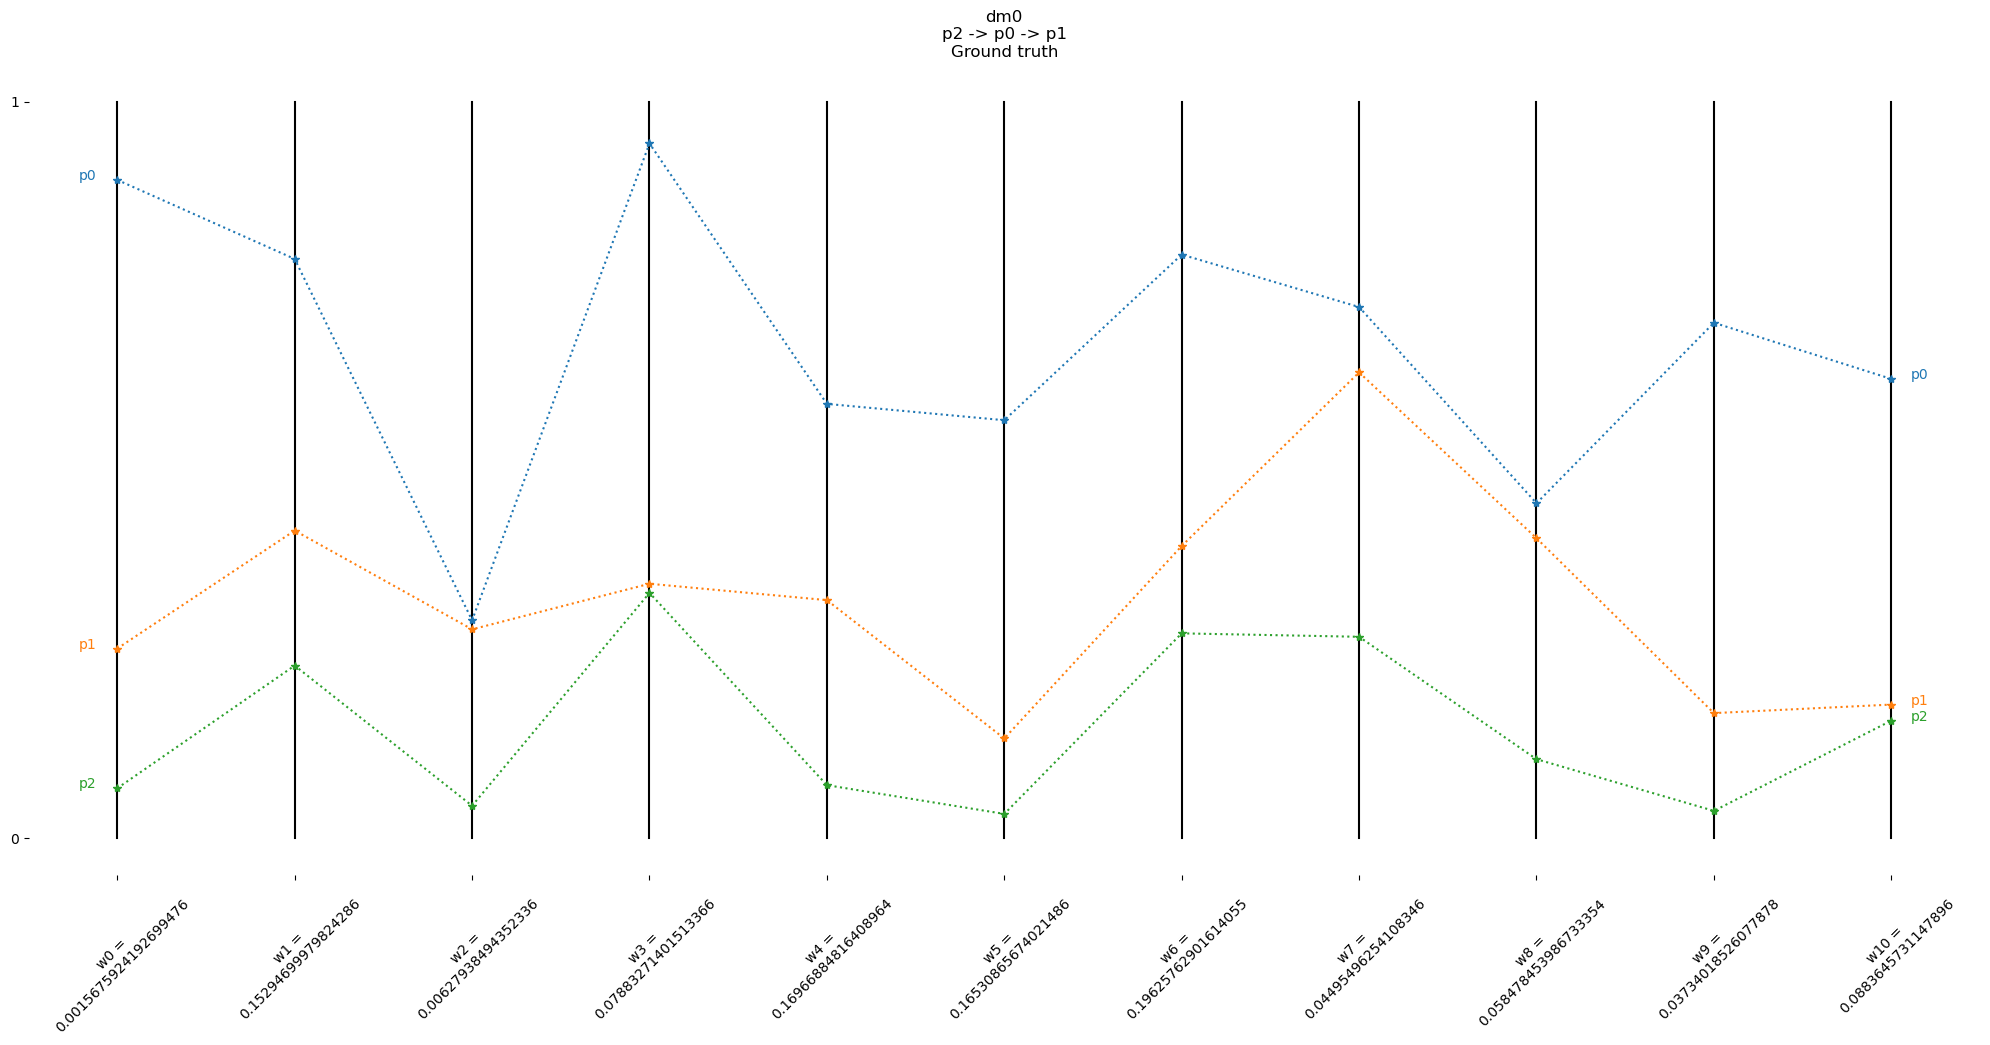

In [61]:
# Plot ground truth
if ARGS.debug_mode :
    plot_decision_maker(ground_truth_decision_maker, title="Ground truth", file_name=ARGS.output_directory + "decision_maker_ground_truth.png")

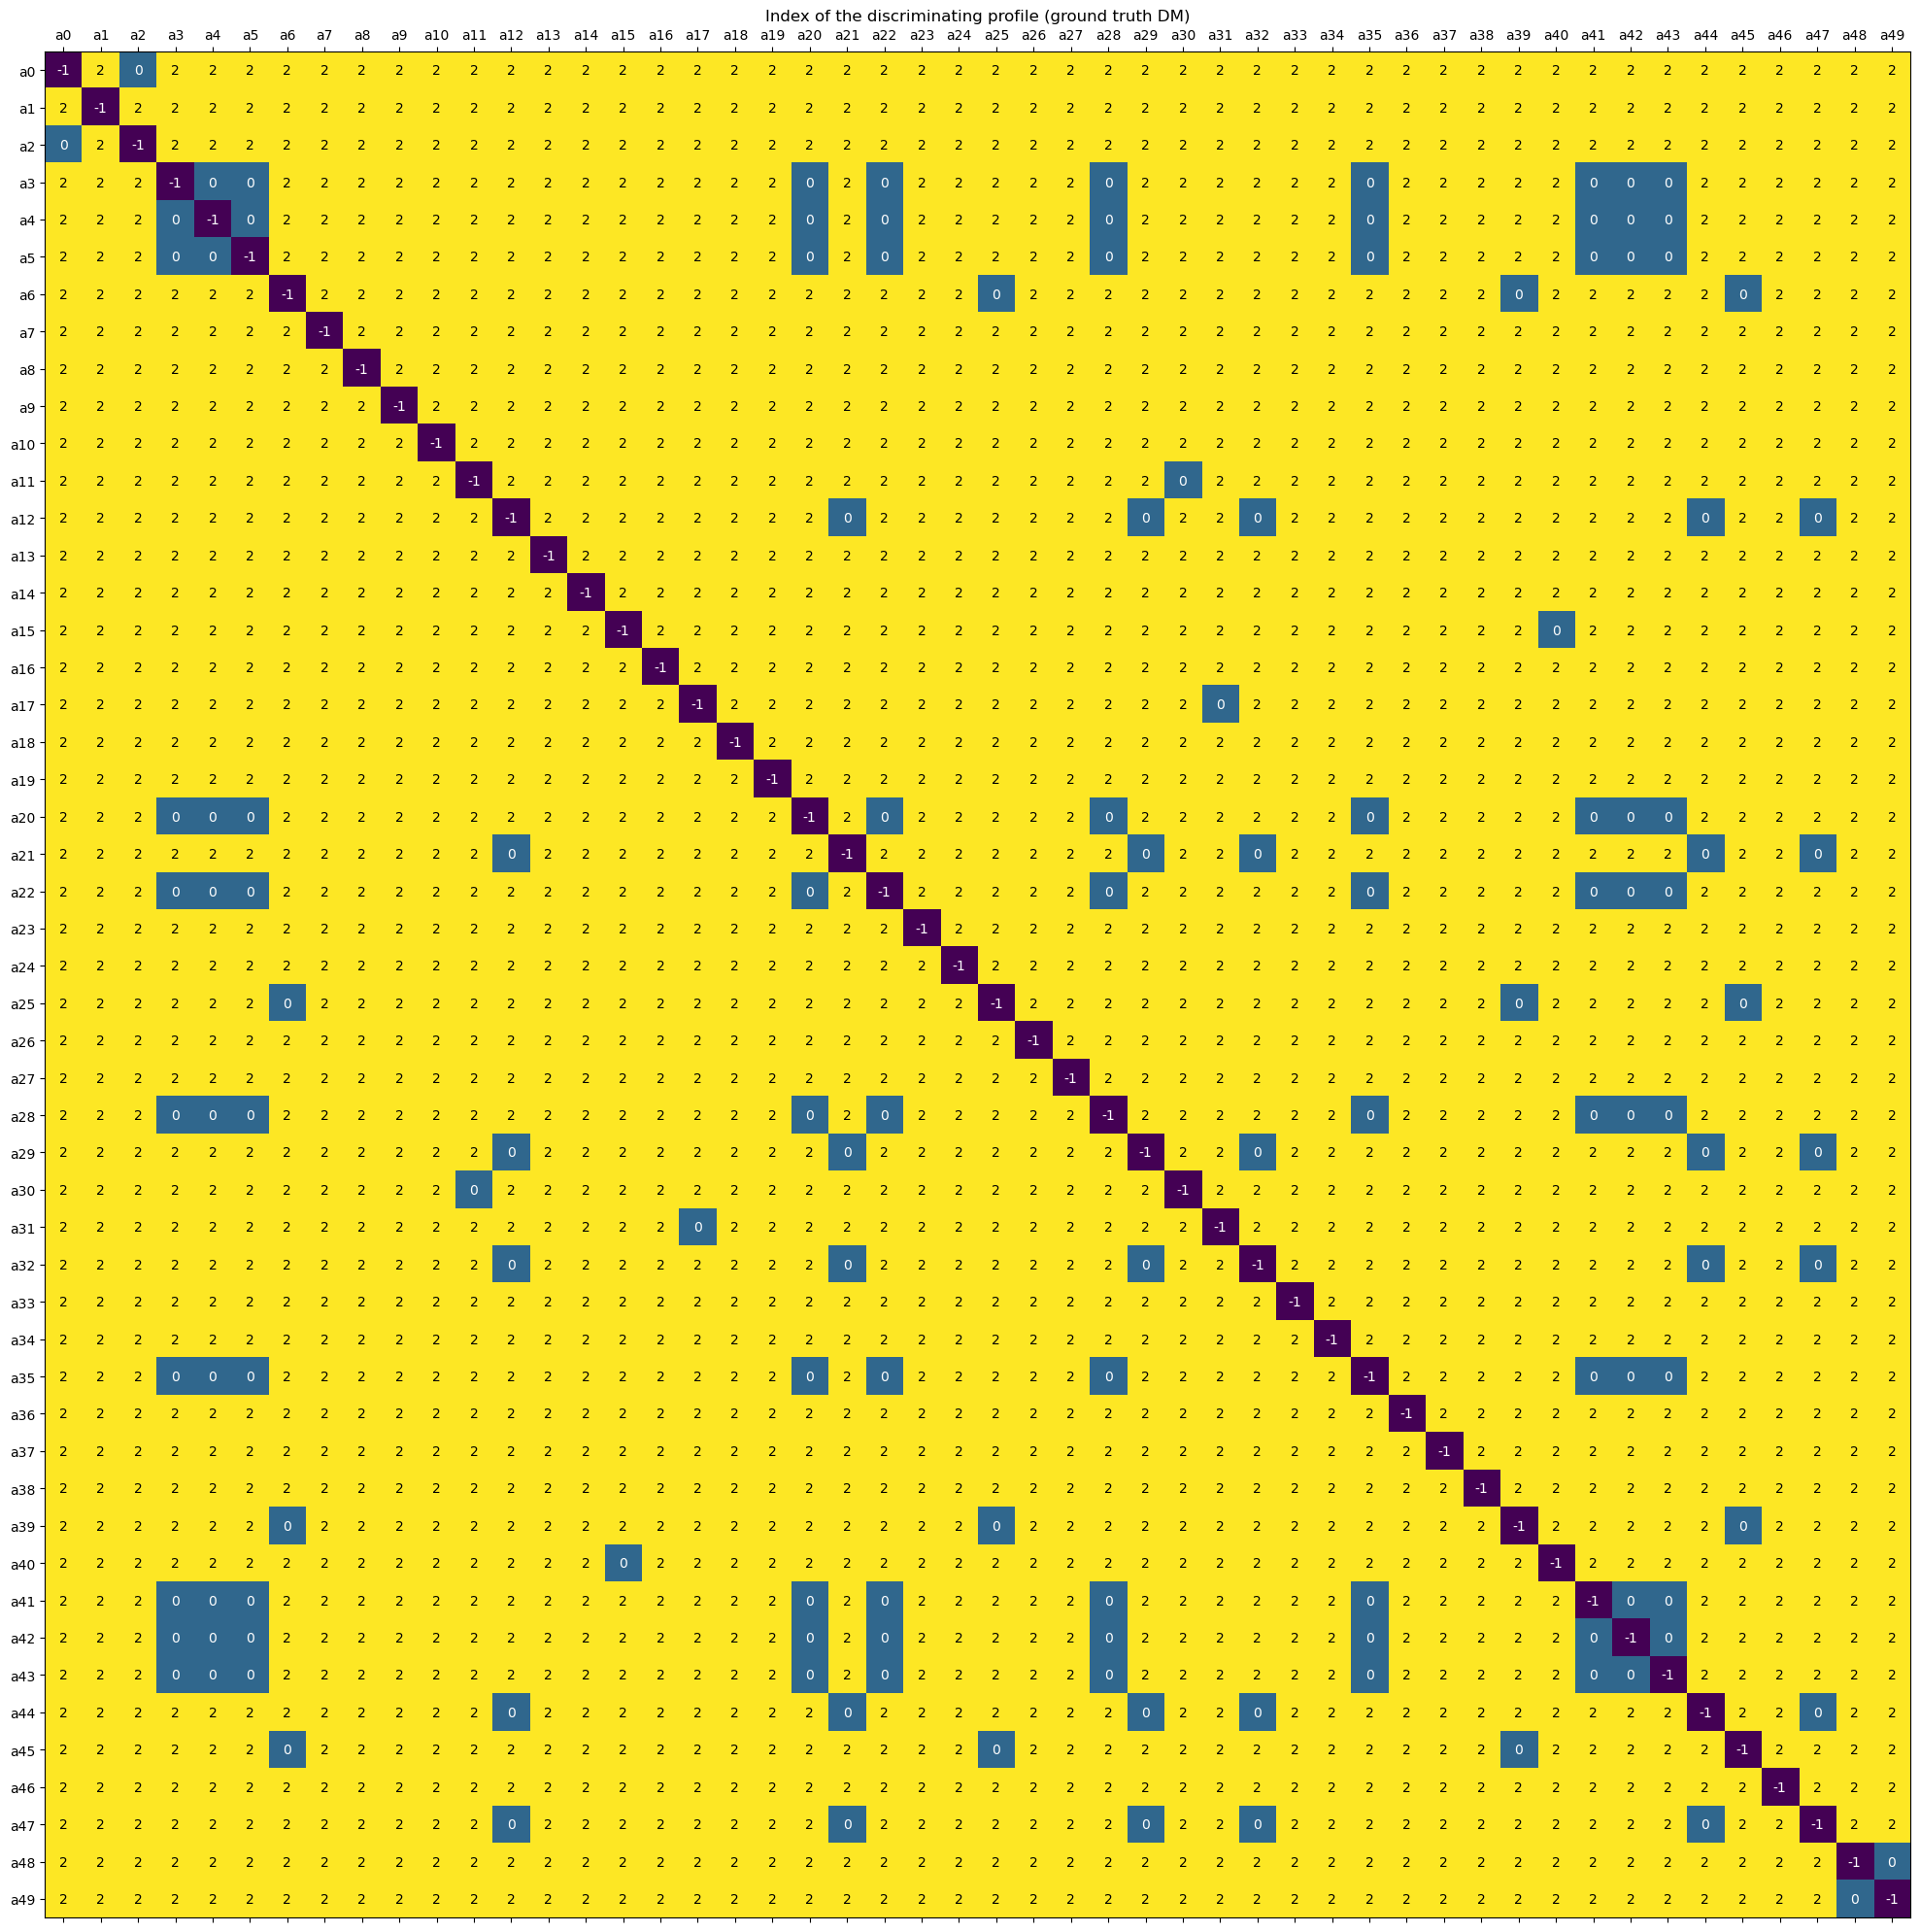

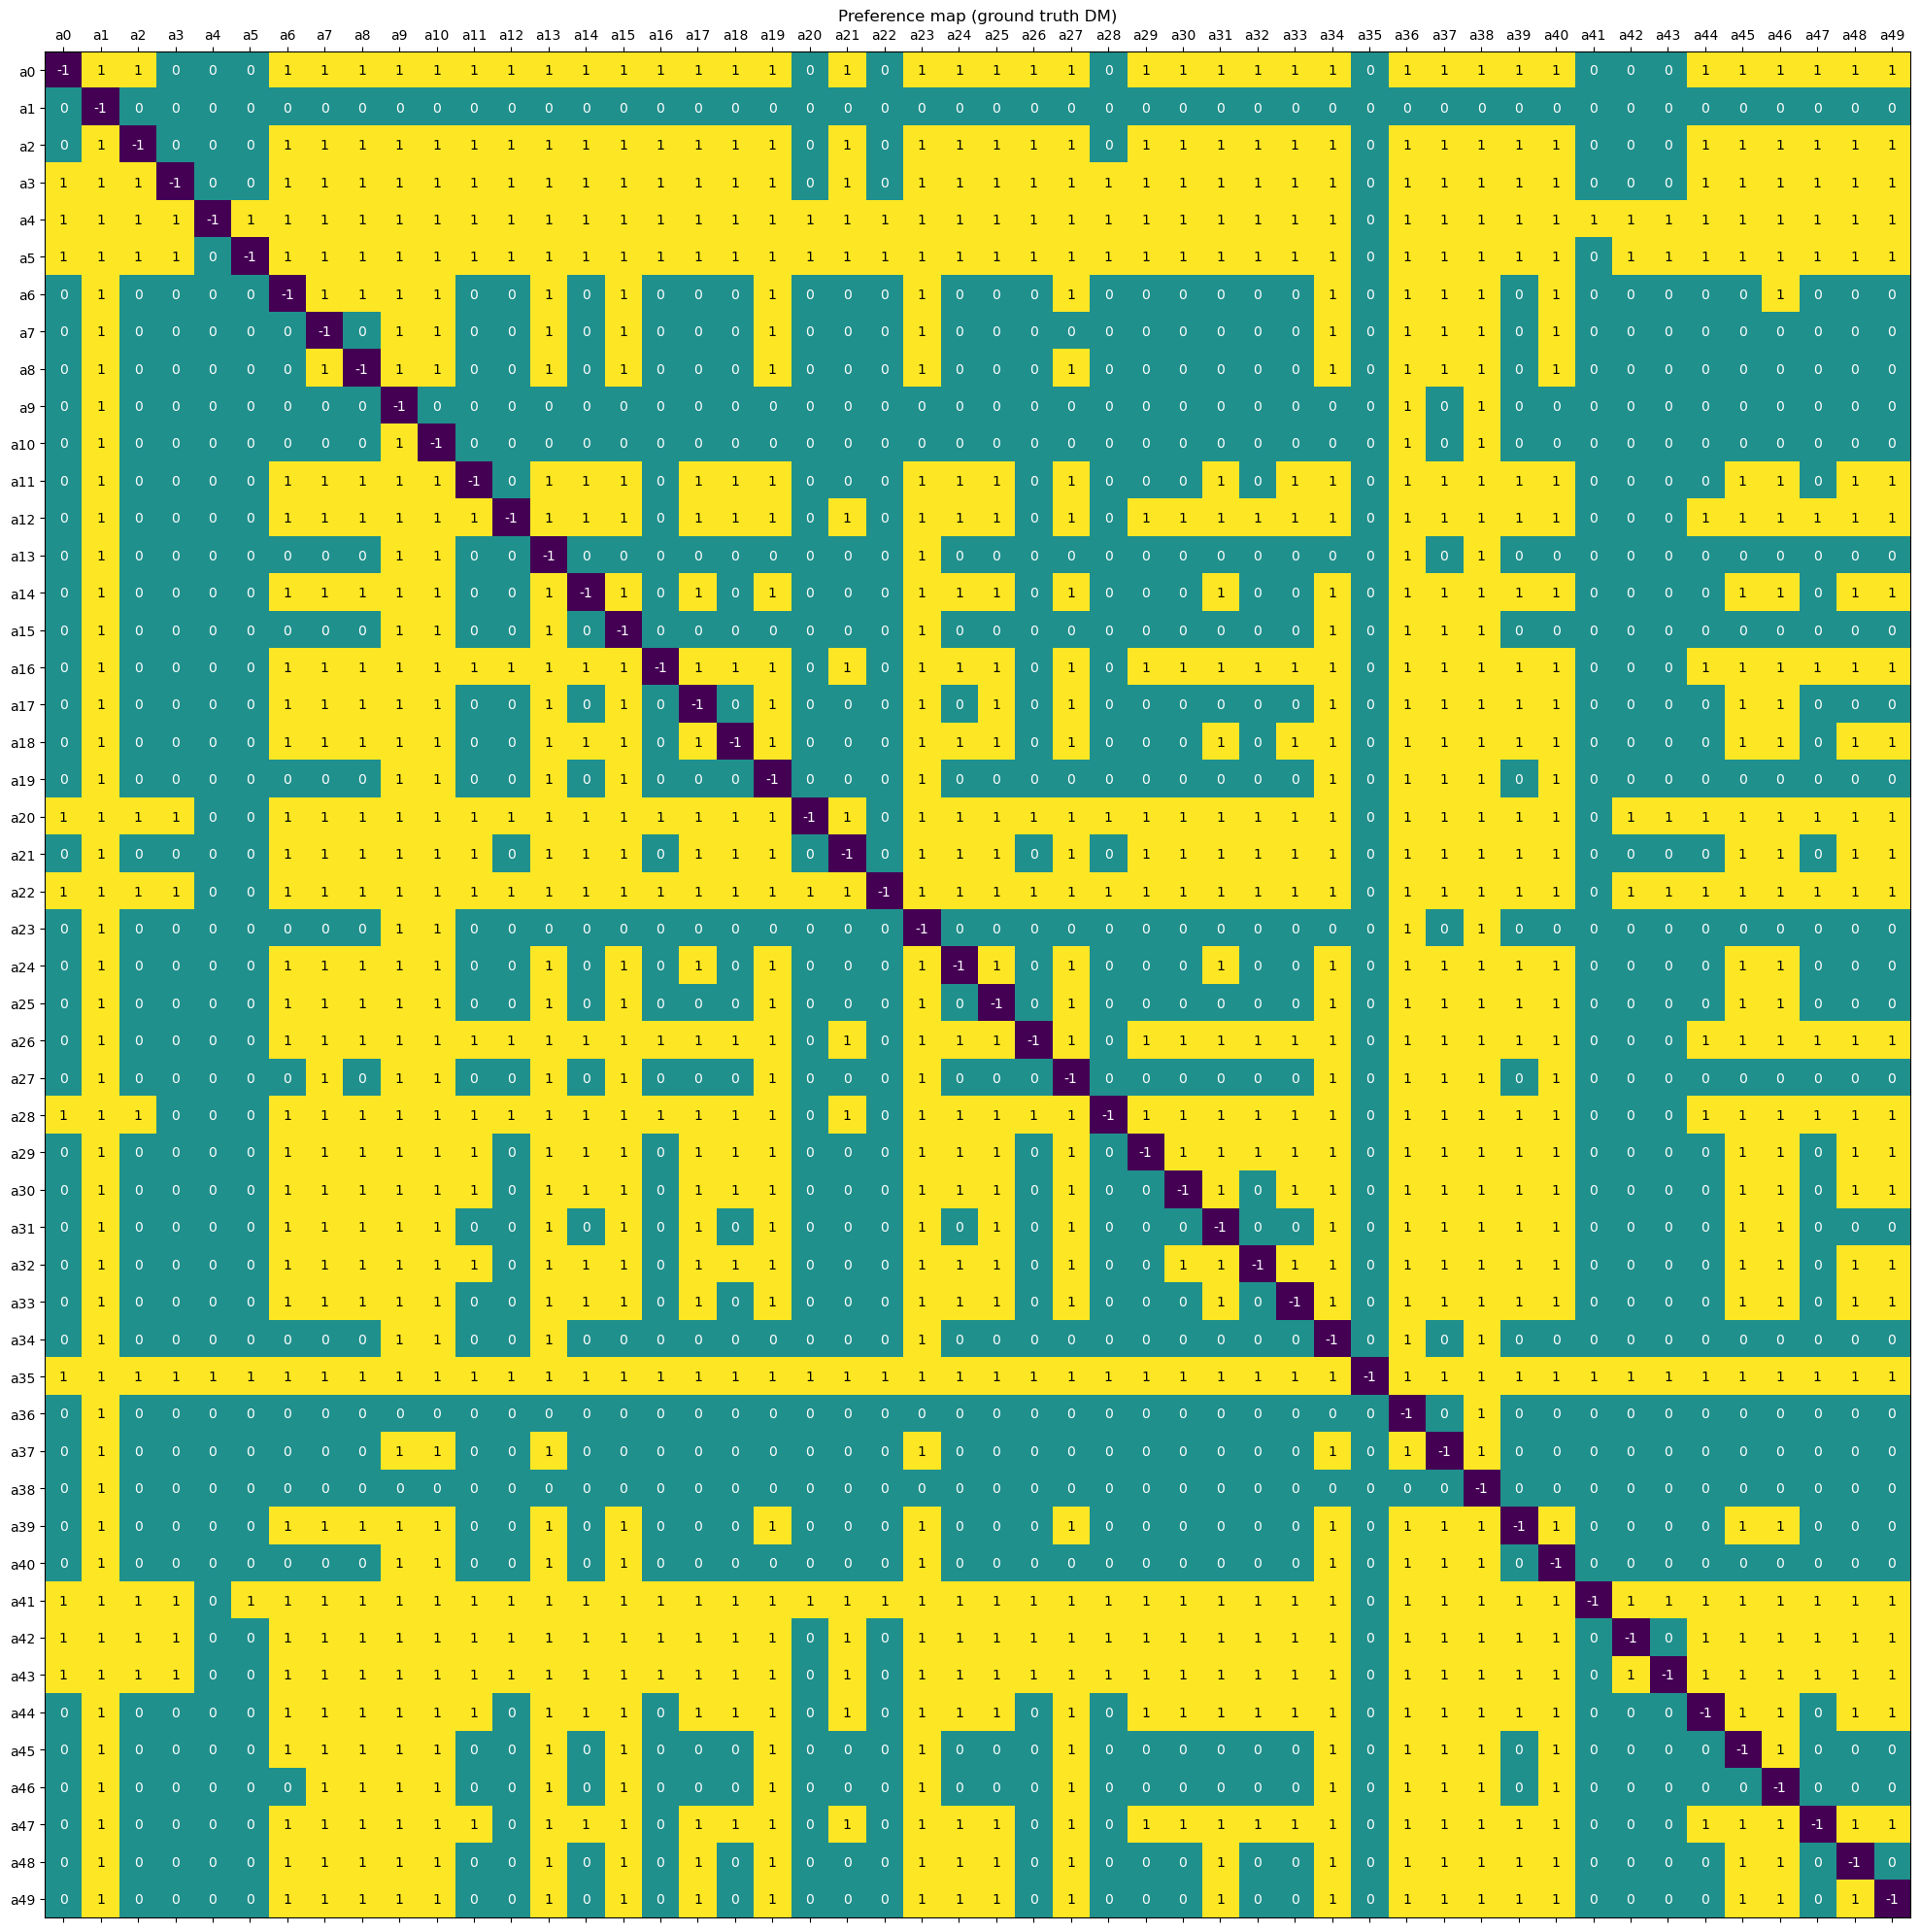

In [62]:
# Check which profiles are useful
if ARGS.debug_mode :
    discriminating_profiles, preferences = compute_all_preferences(ground_truth_decision_maker, alternatives)
    plot_matrix(discriminating_profiles, rows_labels=["a" + str(alternative["id"]) for alternative in alternatives], cols_labels=["a" + str(alternative["id"]) for alternative in alternatives], title="Index of the discriminating profile (ground truth DM)", round_values=0, file_name=ARGS.output_directory + "discriminating_profiles_ground_truth.png")
    plot_matrix(preferences, rows_labels=["a" + str(alternative["id"]) for alternative in alternatives], cols_labels=["a" + str(alternative["id"]) for alternative in alternatives], title="Preference map (ground truth DM)", round_values=0, file_name=ARGS.output_directory + "preferences_ground_truth.png")

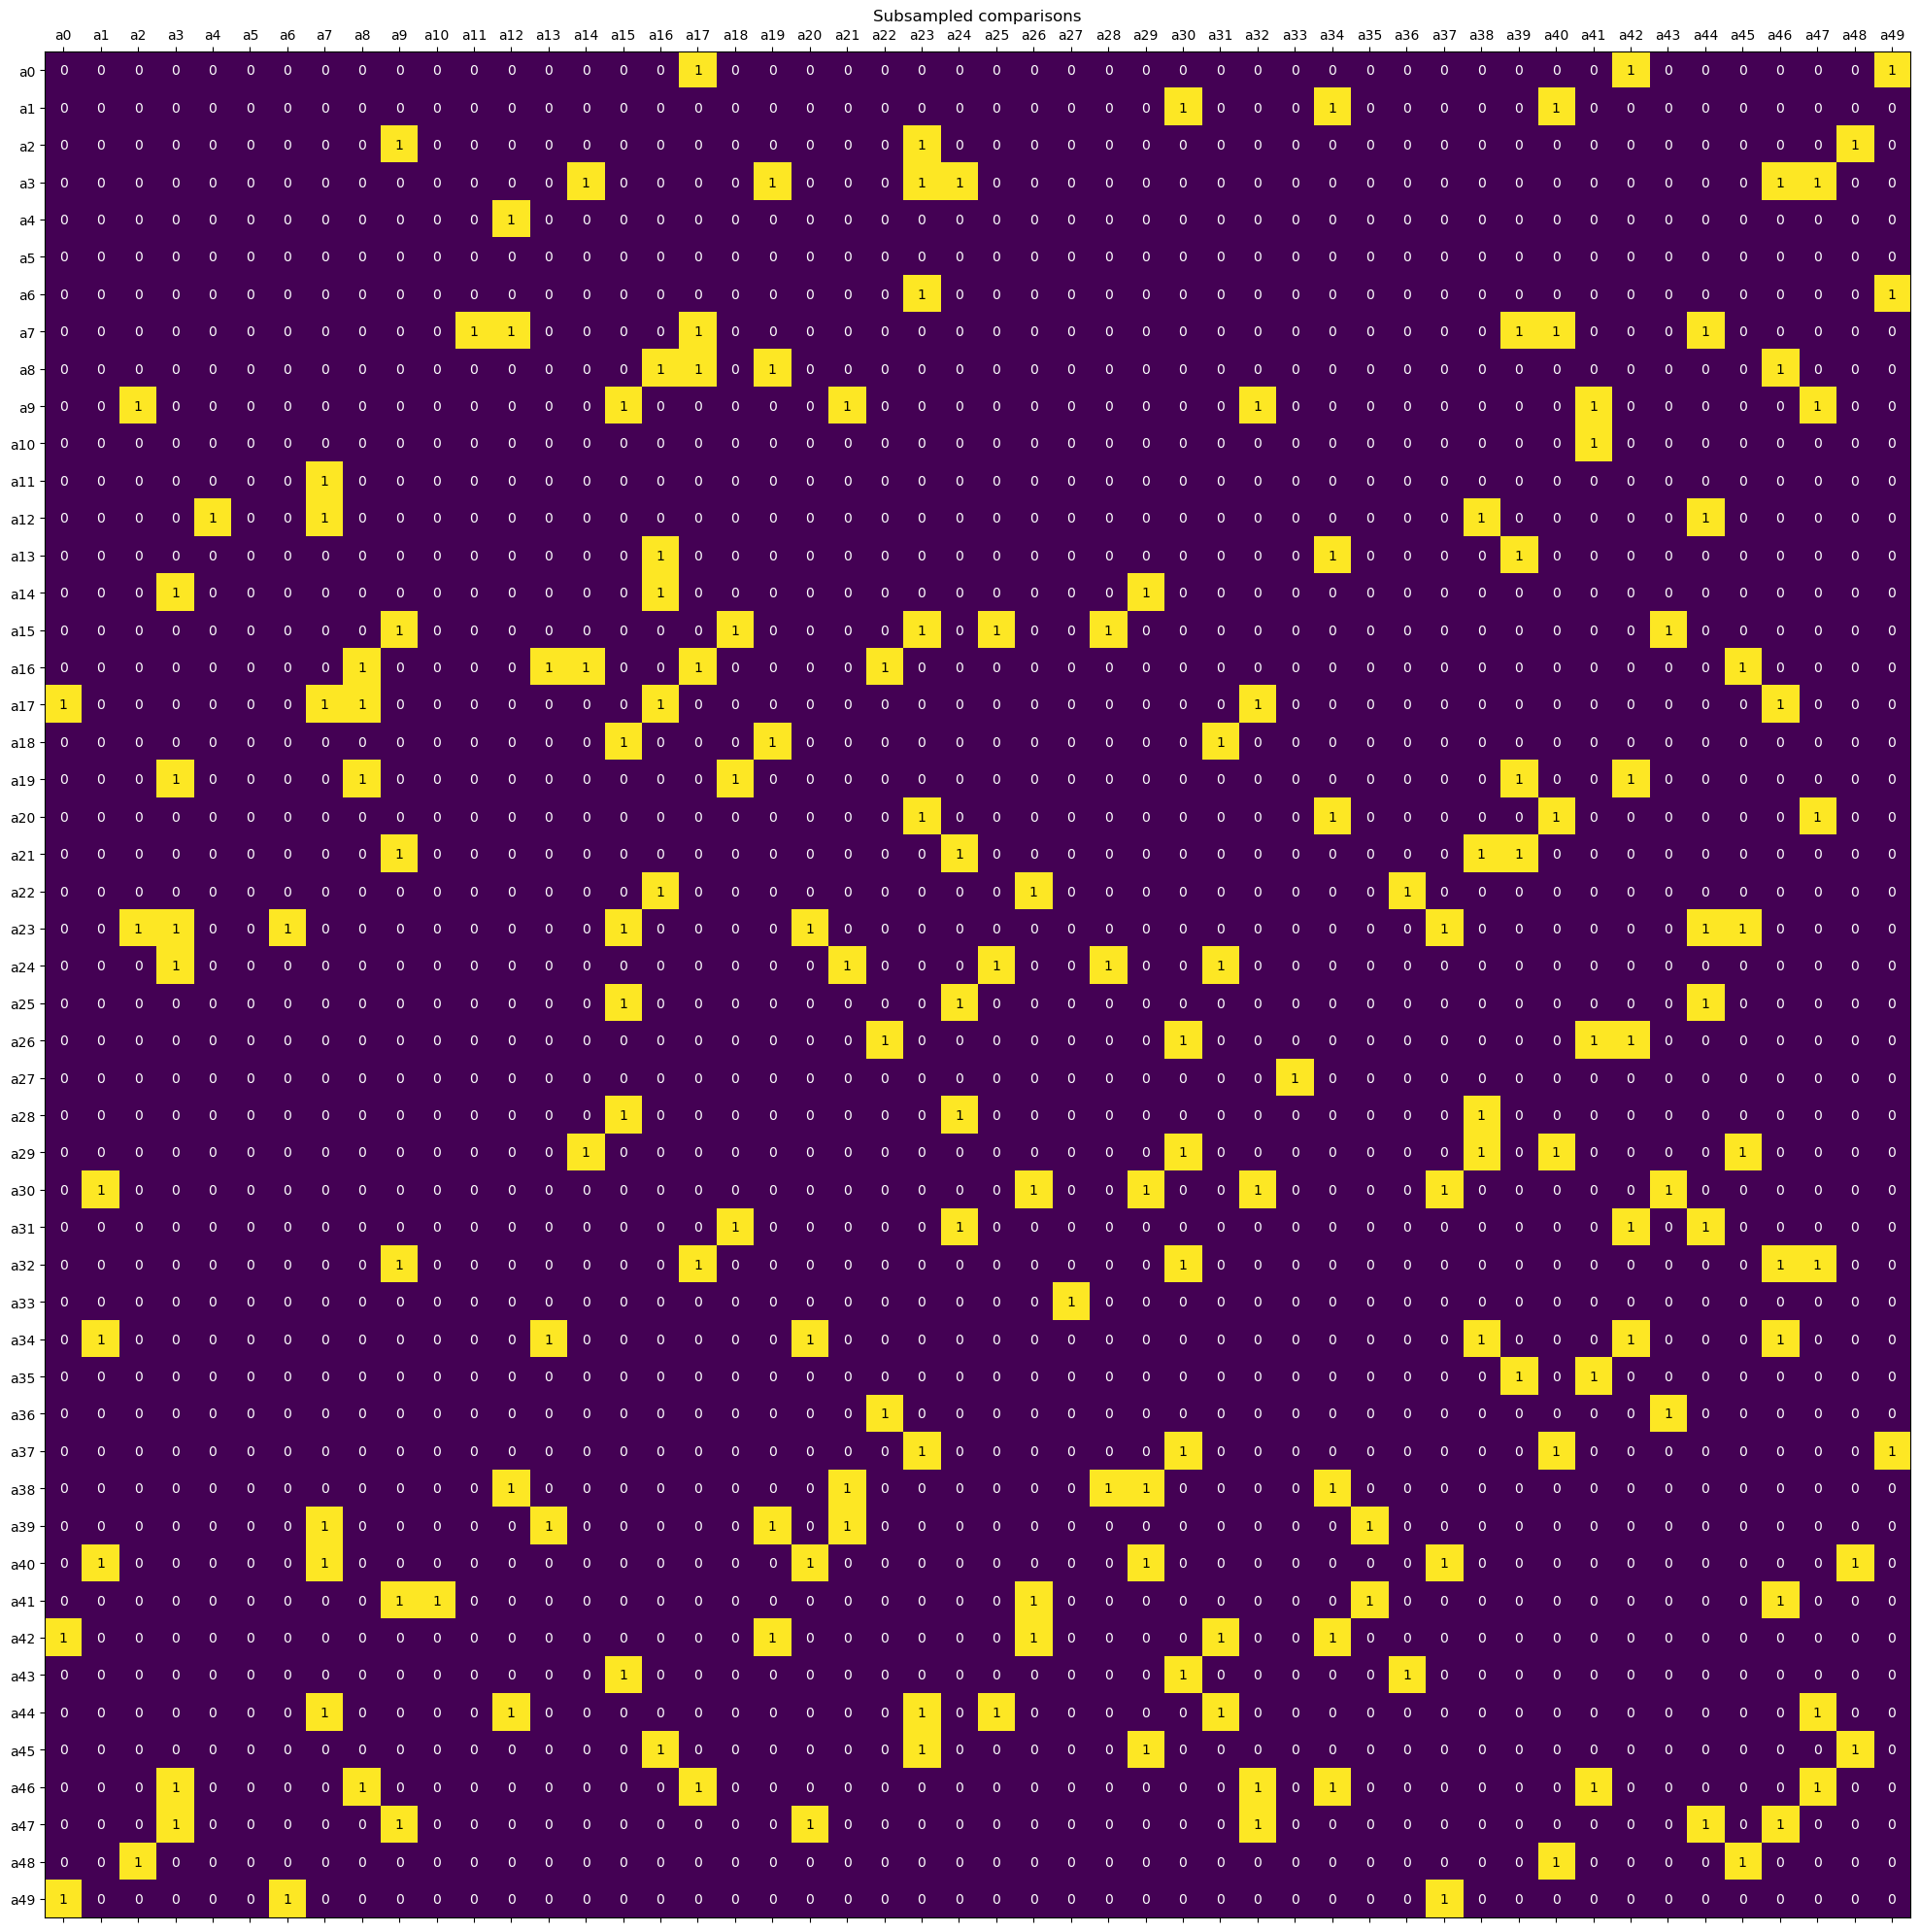

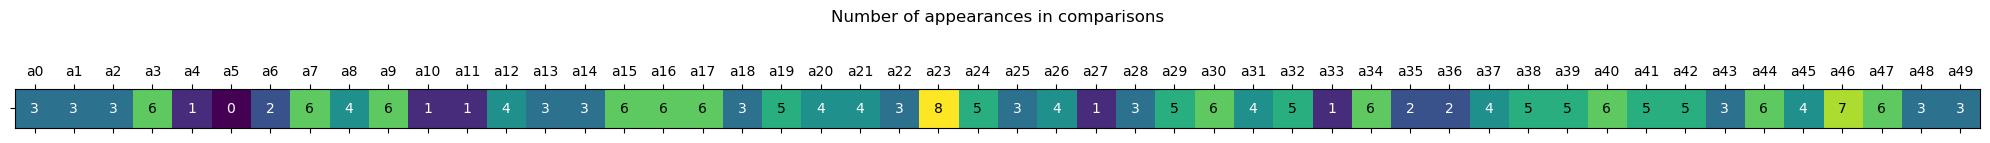

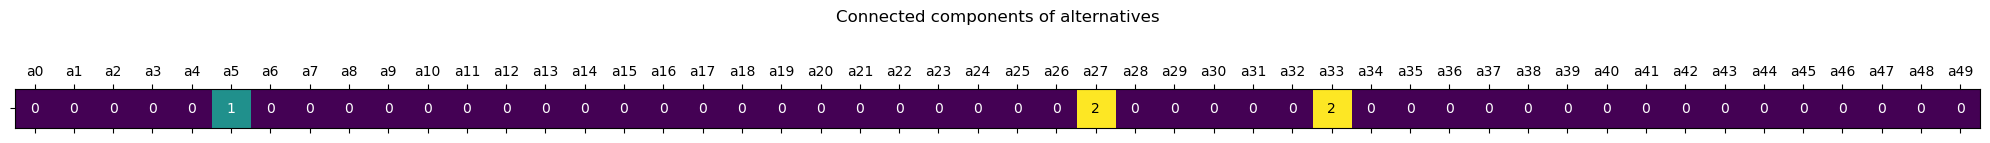

In [63]:
# Check if sampling is sufficient
if ARGS.debug_mode :
    plot_matrix(sampling_matrix, rows_labels=["a" + str(alternative["id"]) for alternative in alternatives], cols_labels=["a" + str(alternative["id"]) for alternative in alternatives], title="Subsampled comparisons", round_values=0, file_name=ARGS.output_directory + "training_set.png")
    plot_matrix(numpy.sum(sampling_matrix, axis=0).reshape(1, ARGS.nb_alternatives), cols_labels=["a" + str(alternative["id"]) for alternative in alternatives], title="Number of appearances in comparisons\n\n", round_values=0, file_name=ARGS.output_directory + "training_set_counts.png")
    plot_matrix(sparse.csgraph.connected_components(sparse.csr_matrix(sampling_matrix), directed=False, return_labels=True)[1].reshape(1, ARGS.nb_alternatives), cols_labels=["a" + str(alternative["id"]) for alternative in alternatives], title="Connected components of alternatives\n\n", round_values=0, file_name=ARGS.output_directory + "training_set_connected_components.png")

<h2>Solve it</h2>

Iteration 0 took 12.42244577407837 seconds.
Number of iterations with no evolution: 0

Iteration 1 took 16.17648720741272 seconds.
Number of iterations with no evolution: 0

Iteration 2 took 18.719162940979004 seconds.
Number of iterations with no evolution: 0

Iteration 3 took 20.496229648590088 seconds.
Number of iterations with no evolution: 0

Iteration 4 took 21.24219036102295 seconds.
Number of iterations with no evolution: 0

Iteration 5 took 22.0953311920166 seconds.
Number of iterations with no evolution: 0

Iteration 6 took 21.05320405960083 seconds.
Number of iterations with no evolution: 0

Iteration 7 took 19.12767267227173 seconds.
Number of iterations with no evolution: 0

Iteration 8 took 20.9546480178833 seconds.
Number of iterations with no evolution: 0

Iteration 9 took 22.538596391677856 seconds.
Number of iterations with no evolution: 0

Iteration 10 took 19.77928614616394 seconds.
Number of iterations with no evolution: 0

Iteration 11 took 25.0698025226593 second

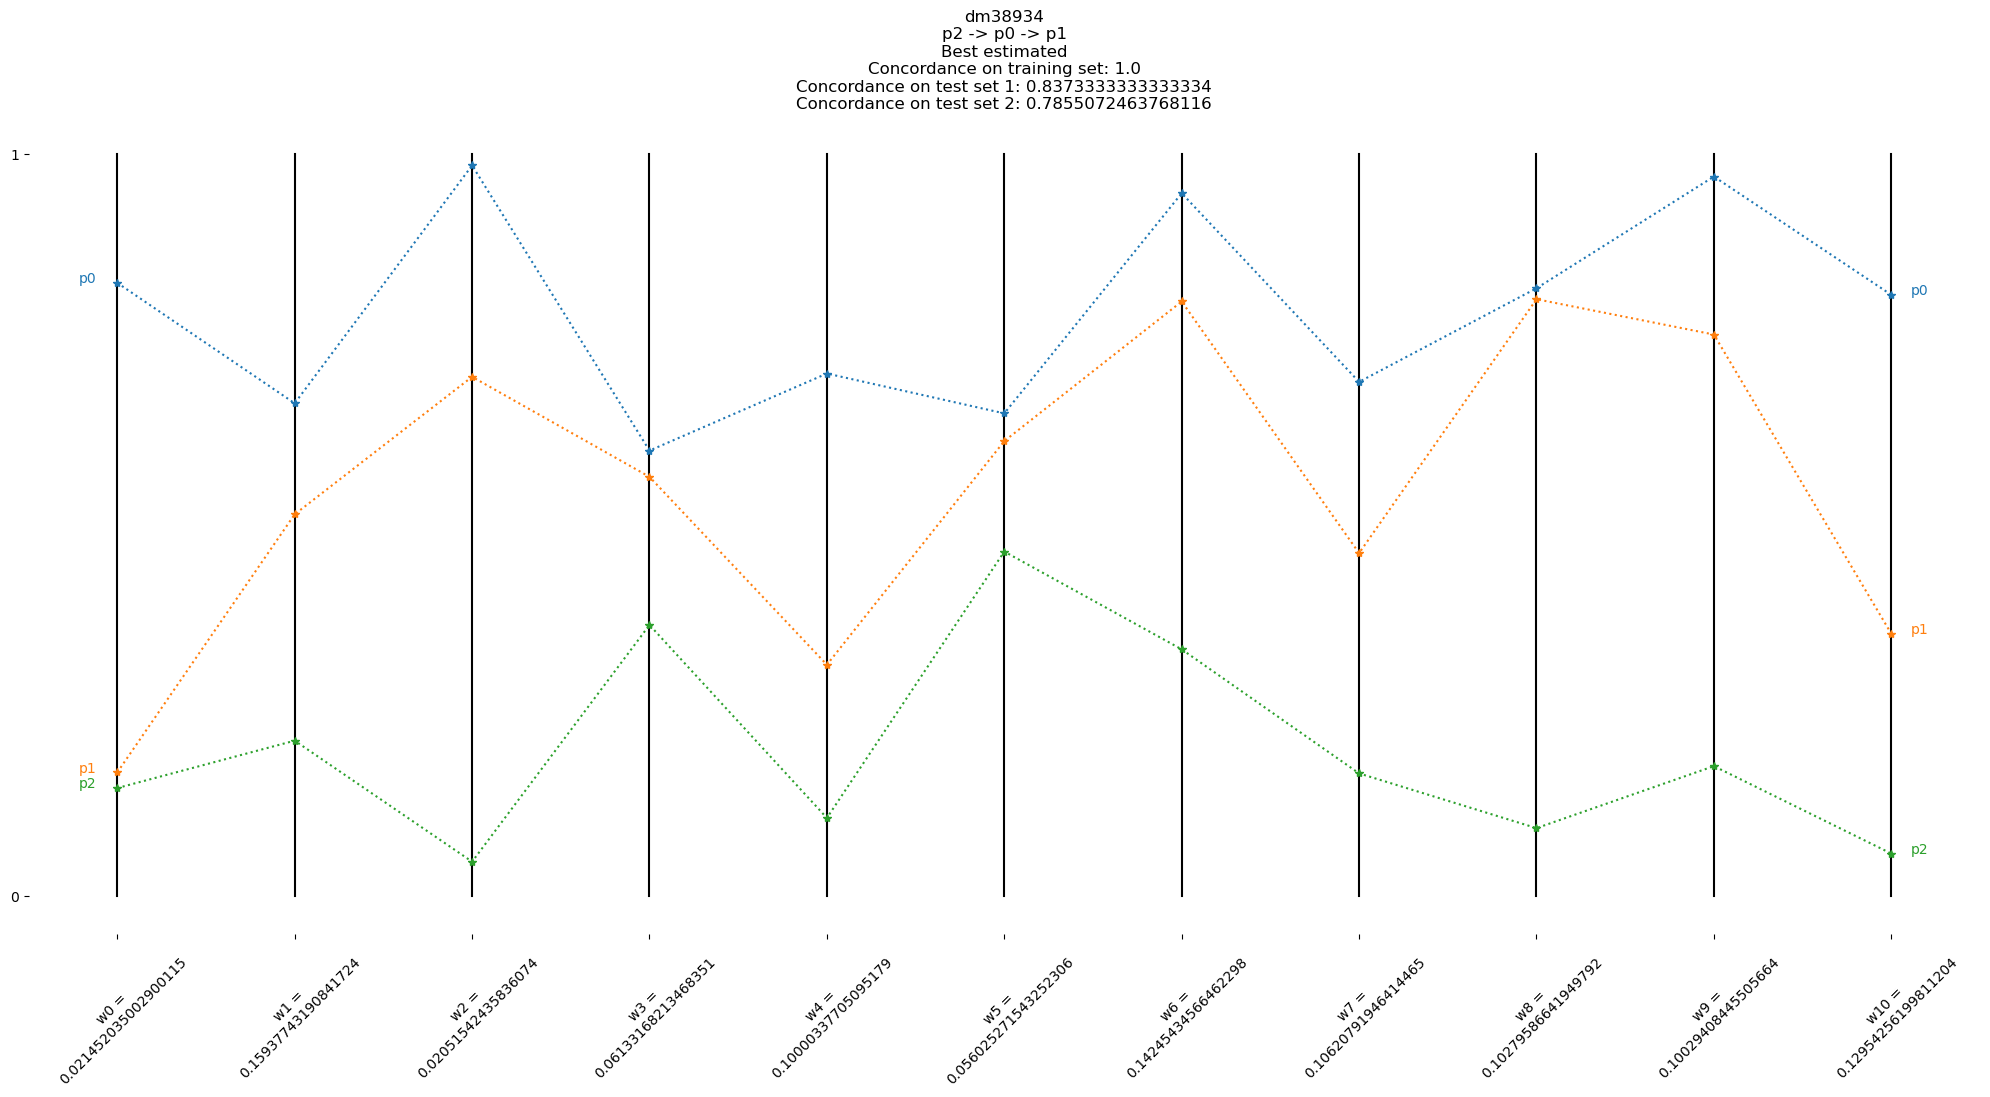

Could not find kcachegrind. Tried: kcachegrind, qcachegrind


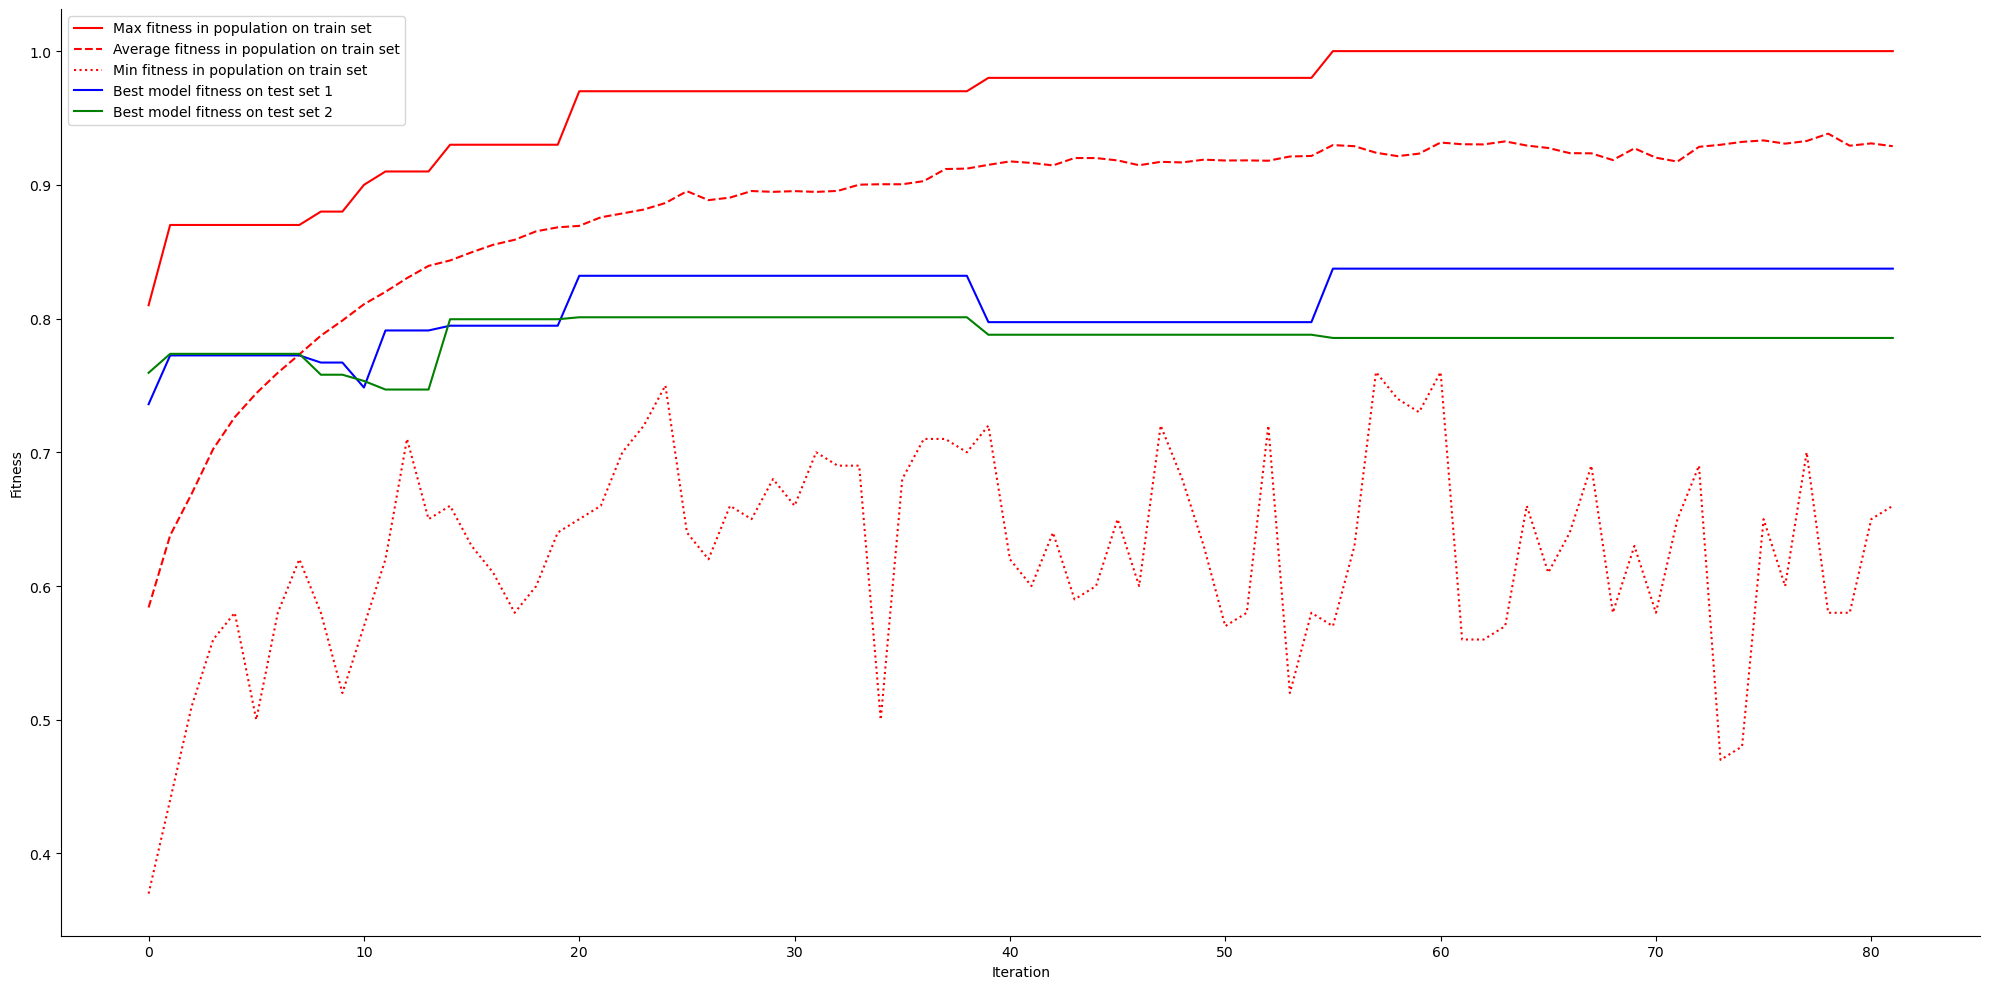

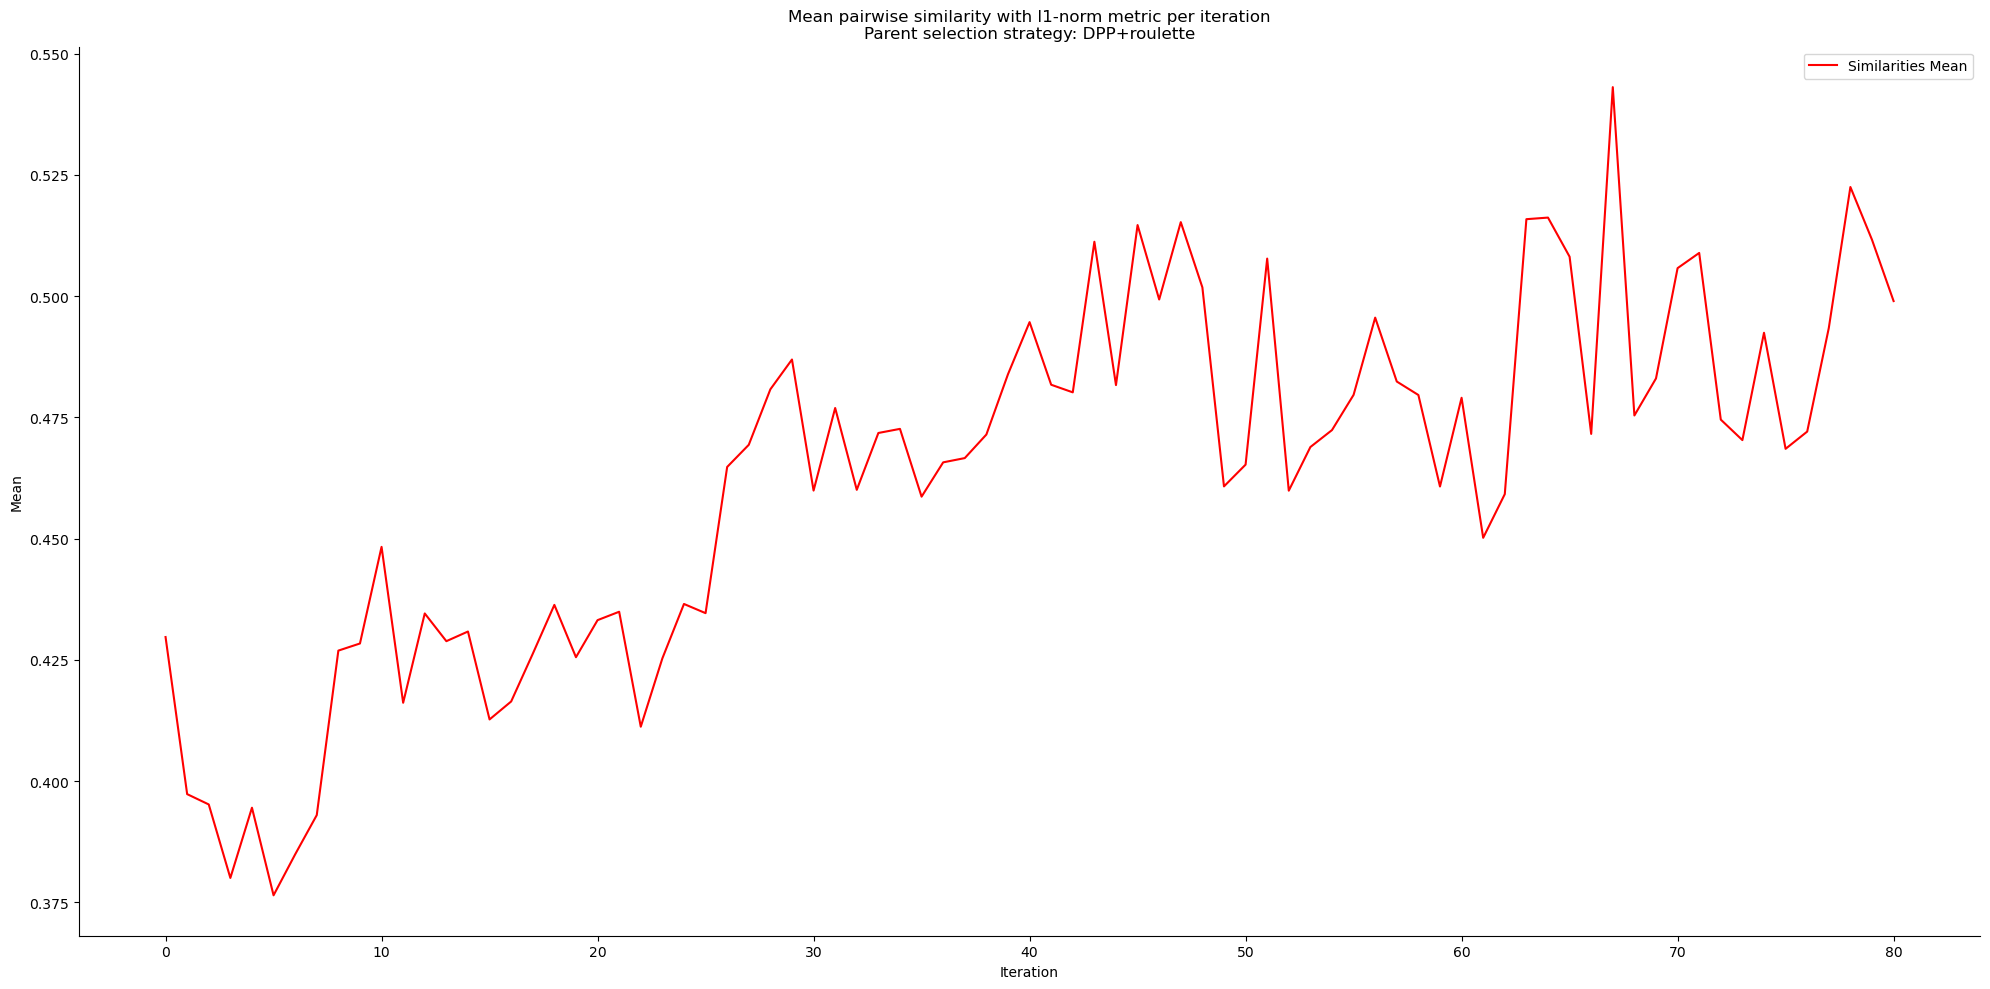

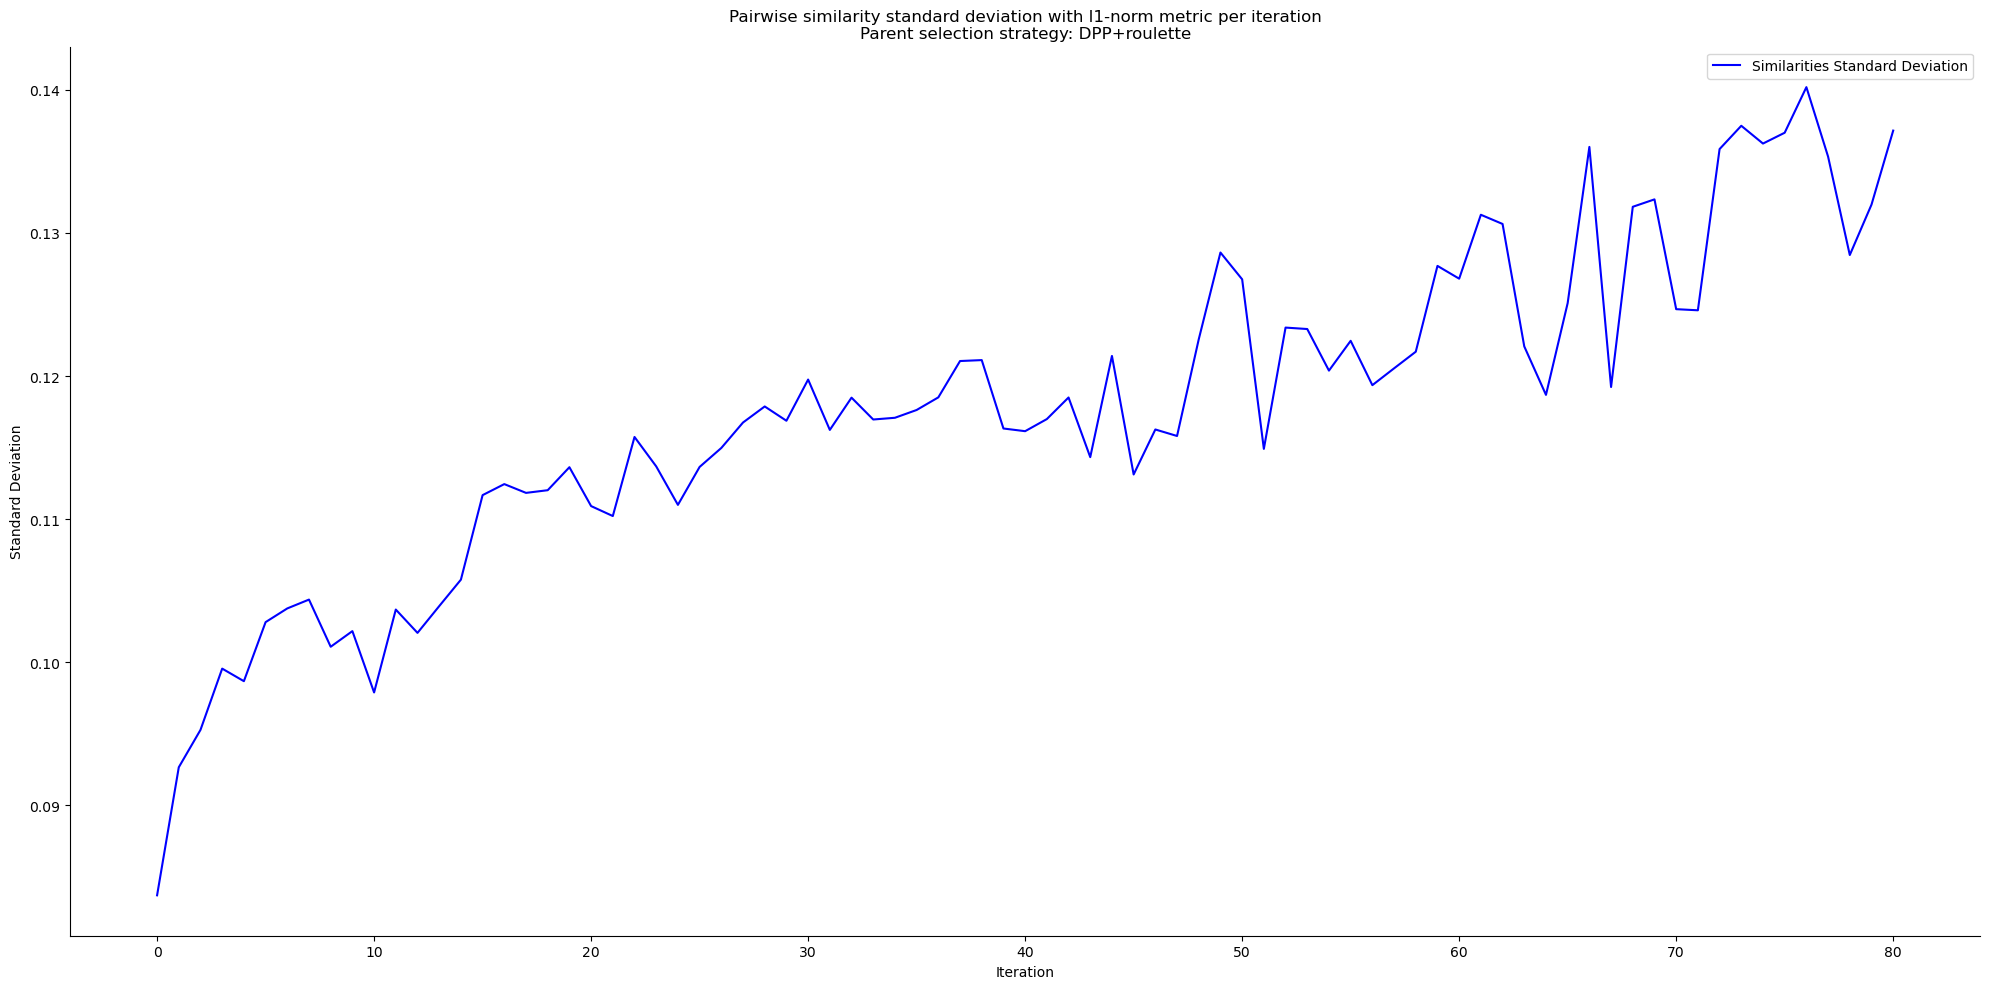

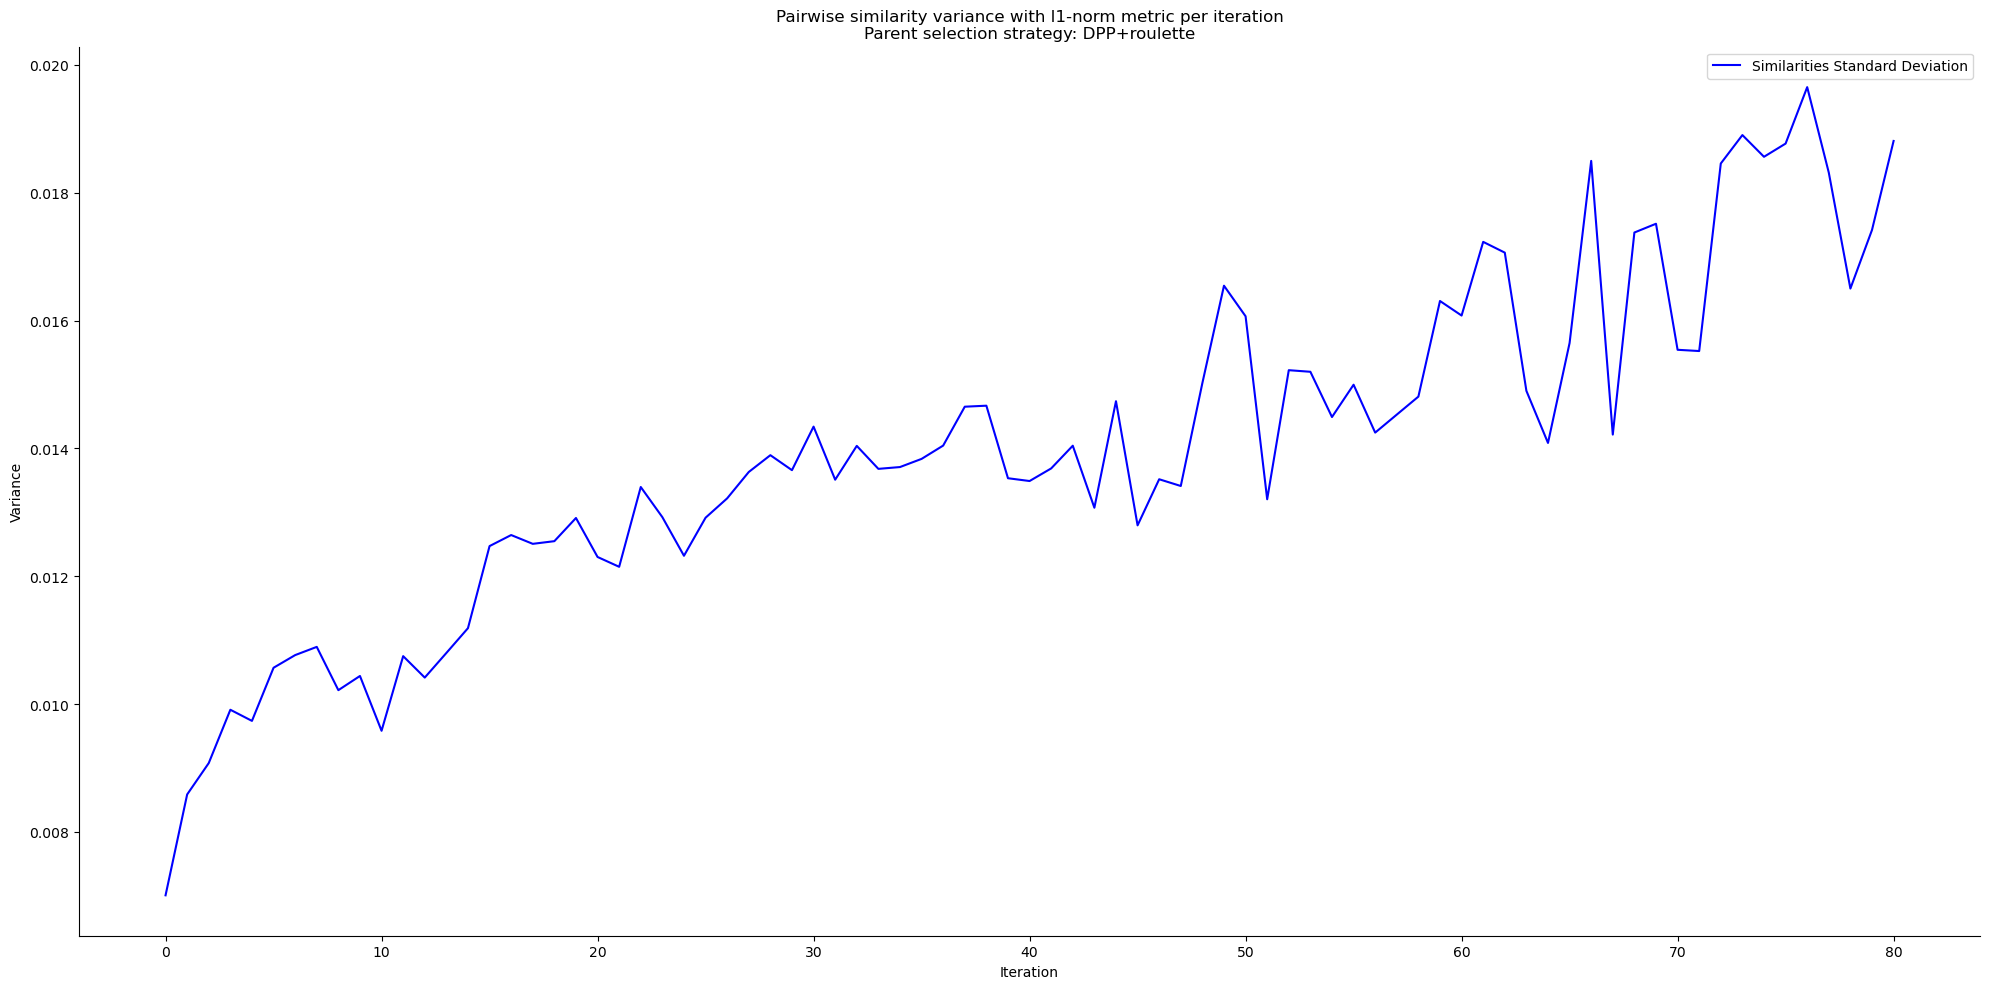

In [64]:
# Solve the problem
if ARGS.debug_mode :
    start_profiling()
start_time = time.process_time()
estimated_decision_makers = estimate_decision_maker(training_set, alternatives, test_sets=test_sets)
stop_time = time.process_time()
if ARGS.debug_mode :
    stop_profiling()

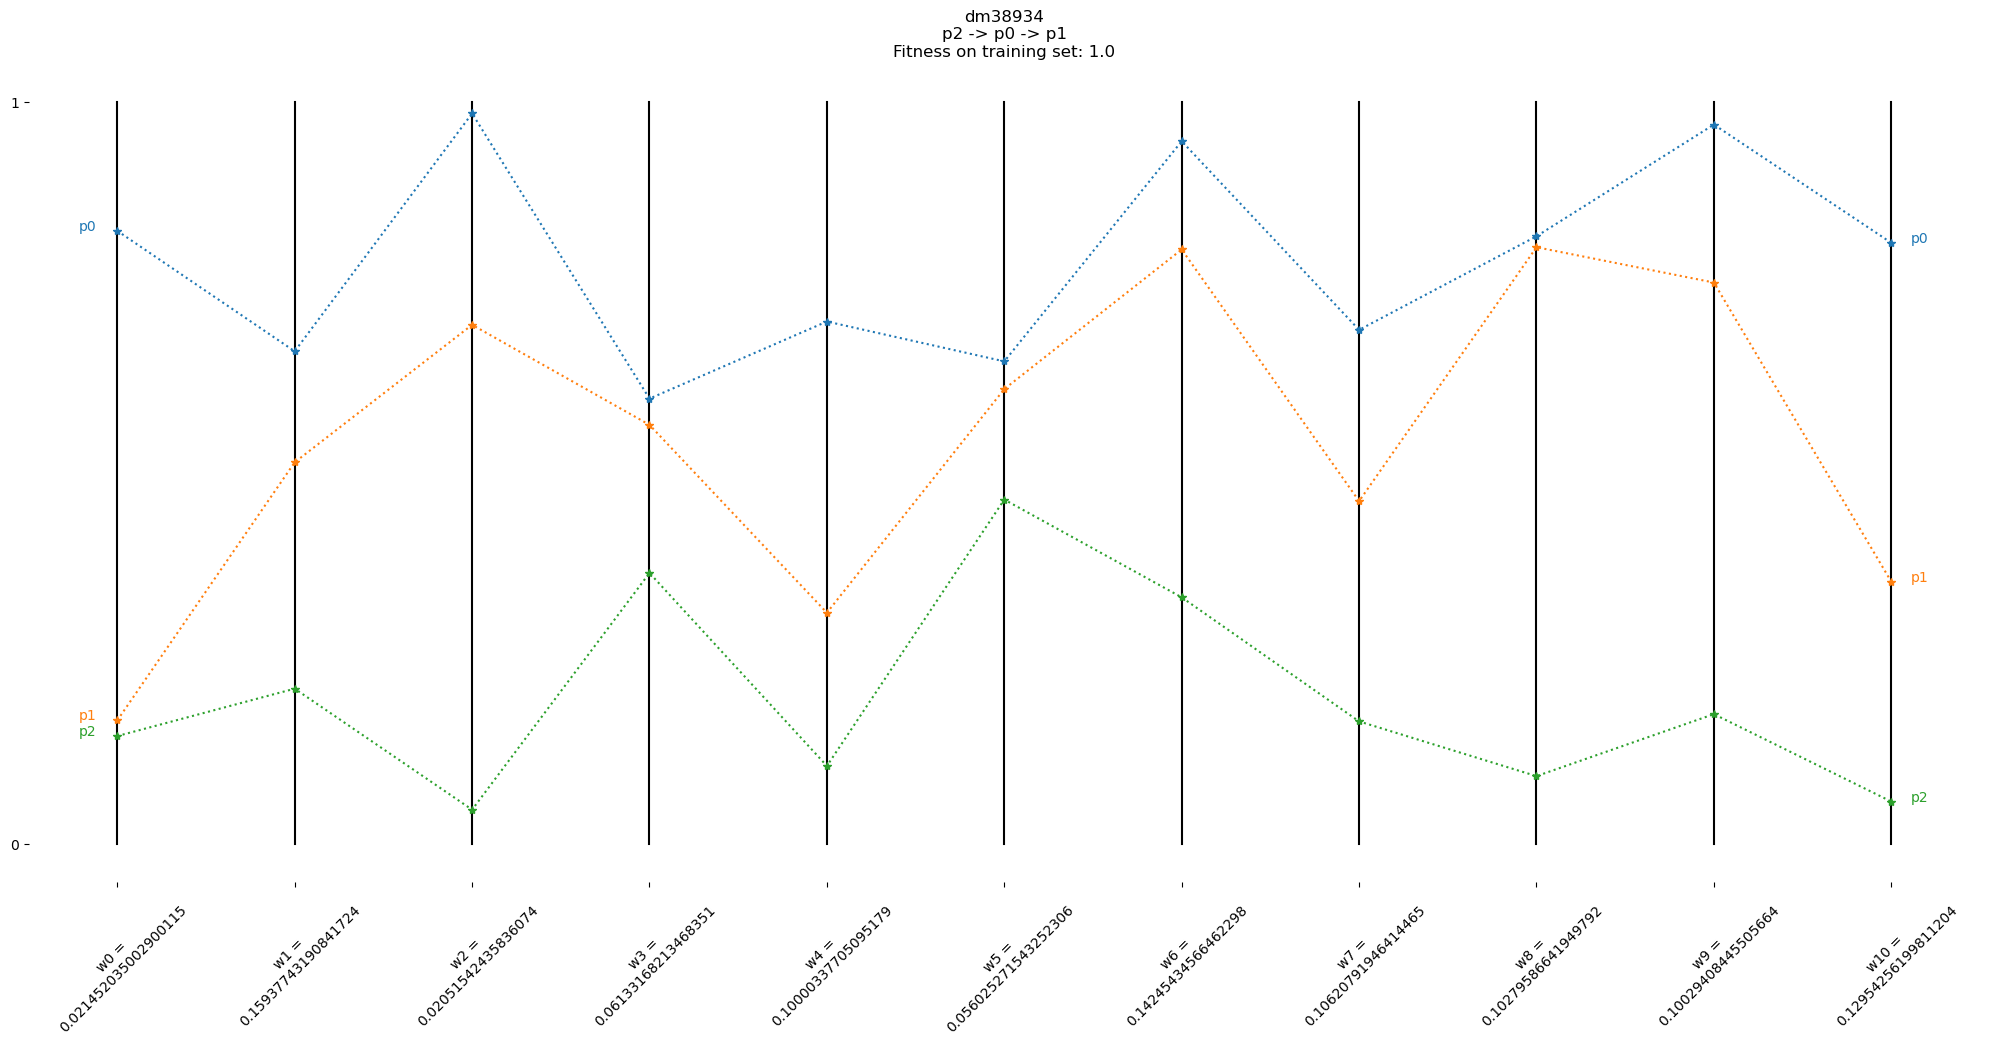

In [65]:
# Show all decision makers
if ARGS.debug_mode :
    for estimated_decision_maker in estimated_decision_makers :
        plot_decision_maker(estimated_decision_maker[1], title="Fitness on training set: " + str(estimated_decision_maker[0]))

In [66]:
# We output the best model final performance on all datasets
results = {}
results["time"] = stop_time - start_time
results["train"] = estimated_decision_makers[0][0]
if len(test_set_1) > 0 :
    results["test_1"] = compute_fitness(estimated_decision_makers[0][1], test_set_1)
if len(test_set_2) > 0 :
    results["test_2"] = compute_fitness(estimated_decision_makers[0][1], test_set_2)
print(results)

{'time': 7862.203125, 'train': 1.0, 'test_1': 0.8373333333333334, 'test_2': 0.7855072463768116}
